In [1]:
# https://discover.data.vic.gov.au/dataset/crash-stats-data-extract

[TFM](https://github.com/jmrplens/TFG-TFM_EPS)

# Diagrama de flujo

<center><img width='600px' src="Data/Data_flow.png"/></center>

Metodología
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=294849

# Métodos

## Carga Google Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Versión y especificación de directorios

In [78]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
%load_ext autoreload
%autoreload 2


%load_ext tensorboard

In [5]:
from datetime import datetime

MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")


WEIGHTS_PATH  = './feature_weights/'
REPORTS_PATH  = 'Reports/'
MODELS_PATH   = 'Models/'
F1_SCORES_PATH = 'F1scores/'
GA_SCORES_PATH = 'GA_Scores/'
HYPERPARAMS_PATH = './hyperparams/'

HYPERPARAMS_EVOLUTON_PATH = './hyperparams_evolution/'
FINAL_POPULATION_PATH  = './population/'
CONFUSIONS_MATRIX_PATH = 'confusion_matrix/'
TSNE_PATH = 'tsne/'

REPORTS_TIMES_PATH = 'times/'


###### MODELS ######
MODELS_NAME = ['knn', 'convolution_1d', 'convolution_2d', 'nb', 'svc', 'auto_ml']
MODELS_NAME = ['nb', 'svc', 'knn', 'logistic_regression', 'random_forest', 'mlp', 'convolution_1d', 'convolution_2d', 'auto_ml']

REPORTS_SUMMARY_PATH = f"{REPORTS_PATH}summary/"
######## CONFIG ########


In [6]:
%load_ext autoreload
%autoreload 2

laptop = True
calculate_weights = True
tsne = False

leeds  = False
madrid = False
UK = True

tree_method = 'auto' if laptop else 'gpu_hist'

train_nn = True
other_models = cnn1d = True
cnn1d = False
cnn2d = True
other_models = cnn1d = True

calculate_cnn_hyperparams = False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# laptop = True
# calculate_weights = True
# tsne = False

# leeds  = False
# madrid = False
# UK = True

# tree_method = 'auto' if laptop else 'gpu_hist'
# # tree_method = 'gpu_hist'
# train_nn = False
# other_models = cnn1d = False

## Importar Tensorflow

In [8]:
# !pip install tensorflow-addons

In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, BatchNormalization, Add, concatenate, Conv2DTranspose, Flatten

2023-10-11 09:38:22.903728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 09:38:22.974605: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 09:38:22.992982: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-11 09:38:23.293977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [10]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
# !nvidia-smi

Found GPU at: /device:GPU:0


2023-10-11 09:38:23.786200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 09:38:23.885728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 09:38:23.891889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 09:38:23.891983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

## Importador/Exportador JSON

In [11]:
import json

def write_json(feature_vector, root_path, file_name):
    with open(root_path + file_name, 'w') as outfile:
        json.dump(feature_vector, outfile)

def load_json(root_path, file_name):
    with open(root_path + file_name) as json_file:
        data = json.load(json_file)

    return data

## Construcción de imágenes

In [12]:
from src.mixins.utils import get_feature_matrix_indexes
from src.mixins.utils import fv2gi
from src.mixins.utils import get_max_child_numbers
from src.mixins.utils import build_gray_images

## Construcción Feature Vector

In [13]:
def fill_feature_vector(X_dataset,child_weights):
  # Obtenemos el set de columnas del dataset
  train_columns_set  = set(X_dataset.columns)

  for parent_feature in feature_vector.keys():
    # Obtiene el set de características hijas del padre actual
    # dict.fromleys para mantener el orden, un set desordena los valores
    feature_childs_set = dict.fromkeys(feature_vector[parent_feature]['feature_childs'])

    # Obtener el índice de las columnas del actual padre para acceder a los pesos del XGBoost
    index_feature_childs = X_dataset.columns.get_indexer(feature_childs_set)

    feature_vector[parent_feature]['feature_weights'] = list([str(child_weight) for child_weight in child_weights[index_feature_childs]])

  return feature_vector

## Normalización de datos

In [14]:
from scipy.stats import zscore
import pandas as pd

def normalize_data(X_data):

    # Create a sample df
    normalized_df = X_data

    # Calculate the zscores and drop zscores into new column
    for column in normalized_df.columns:
        normalized_df[column] = zscore(normalized_df[column])
    
    return normalized_df

## Oversampling de datos

In [15]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import KMeansSMOTE

def oversample_data(X_data, Y_labels):

    oversampler = BorderlineSMOTE(kind='borderline-2', random_state = 3)
    # oversampler = RandomOverSampler()
    # oversampler = KMeansSMOTE()
    X_oversampled, Y_oversampled = oversampler.fit_resample(X_data, Y_labels)

    print('********** After OverSampling **********')
    # print('Slight: ', (Y_oversampled == 'Slight').sum())
    # print('Serious:', (Y_oversampled == 'Serious').sum())
    # print('Fatal:  ', (Y_oversampled == 'Fatal').sum())
    # print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    print('Slight: ', (Y_oversampled == 'Slight').sum())
    print('Assistance:', (Y_oversampled == 'Assistance').sum())
    print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    return X_oversampled, Y_oversampled

## Algoritmo genético

In [16]:
HYPERPARAMS_TO_OPTIMIZE = {'eta': {'type': 'float',
                                   'init': [0.01, 1],
                                   'mutation': [-0.2, 0.2],
                                   'round': 2
                                   },
                           'max_depth': {'type': 'int',
                                         'init': [1, 25],
                                         'mutation': [-3, 3],
                                         'step': 1
                                   },
                           'min_child_weight': {'type': 'float',
                                                'init': [0.01, 20.0],
                                                'mutation': [-4, 4],
                                                'round': 1
                                   }
                          }

number_of_individuals = 50
numberOfParentsMating = 10
number_of_hyperparams = len(HYPERPARAMS_TO_OPTIMIZE)
number_of_generations = 50

### Inicializar población

In [17]:
def generate_individual(hyperparams_to_optimize):

    individual = []

    for key in hyperparams_to_optimize:
        min_value = hyperparams_to_optimize[key]['init'][0]
        max_value = hyperparams_to_optimize[key]['init'][1]
        data_type = hyperparams_to_optimize[key]['type']
        
        if data_type == 'int':
            step = hyperparams_to_optimize[key]['step']
            hyperparam = int(random.randrange(min_value, max_value))

        if data_type == 'float':
            round_to = hyperparams_to_optimize[key]['round']
            hyperparam = round(random.uniform(min_value, max_value), round_to)

        individual.append(hyperparam)
    
    return individual

def initialize_population(number_of_individuals, hyperparams_to_optimize):
    population = []

    for i in range(number_of_individuals):

        population.append(generate_individual(hyperparams_to_optimize))
      
    return np.array(population)

### Fitness function

In [18]:
from sklearn.metrics import f1_score

def fitness_f1score(y_true, y_pred):

    fitness = round((f1_score(y_true, y_pred, average='micro')), 4)

    return fitness # Train the data annd find fitness score

### Evaluación de población

In [19]:
from xgboost import XGBClassifier
import xgboost as xgb
import time

def train_population(population, hyperparams_to_optimize, dMatrixTrain, dMatrixTest, Y_test):

    fScore = []
    
    params = {'objective':'multi:softprob',
              'tree_method': tree_method,
              'single_precision_histogram': True,
              'num_class': 3
             }

    # params = {'objective':'binary:logistic',
    #           'tree_method': tree_method,
    #           'single_precision_histogram': True
    #          }
    for individual_index in range(population.shape[0]):
        # Se almacenan en hyperparams_to_optimize los valores del individuo con su nombre correspondiente de hyperparams_name_to_optimize.
        hyperparams = {}

        for index, hyperparam_value in enumerate(population[individual_index]):

            hyperparam_name_to_optimize = list(hyperparams_to_optimize.keys())[index]
            data_type = hyperparams_to_optimize[hyperparam_name_to_optimize]['type']

            hyperparams[hyperparam_name_to_optimize] = hyperparam_value
            hyperparams[hyperparam_name_to_optimize] = hyperparams[hyperparam_name_to_optimize].astype(data_type)
        
        params.update(hyperparams)

        # num_round = params['n_estimators']
        
        start = time.time()

        xgb.set_config(verbosity = 0)
        bst = xgb.train(params,
                        dMatrixTrain)

        end = time.time()

        preds = bst.predict(dMatrixTest)
        
        single_predictions = [np.argmax(pred) for pred in preds]
        # preds = preds > 0.5
        fitness_score = fitness_f1score(Y_test, single_predictions)

        # print(f"{individual_index}: {hyperparams} --> time(s): {round(end - start, 2)} --> score: {fitness_score}")

        fScore.append(fitness_score)

    return fScore

### Selección de padres

In [20]:
# Select parents for mating
def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) # Create an array to store fittest parents.

    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 # Set this value to negative, in case of F1-score, so this parent is not selected again

    return selectedParents

### Cruzamiento de población

In [21]:
'''
Mate these parents to create children having parameters from these parents (we are using uniform crossover method)
'''
def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex  = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) # get all the index
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
    children = np.empty(childrenSize)
    
    '''
    Create child by choosing parameters from two parents selected using new_parent_selection function. The parameter values
    will be picked from the indexes, which were randomly selected above. 
    '''
    for i in range(childrenSize[0]):
        
        #find parent 1 index 
        parent1_index = i%parents.shape[0]
        #find parent 2 index
        parent2_index = (i+1)%parents.shape[0]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]

    return children

### Mutación

In [22]:
def mutation(crossover, hyperparams_to_optimize):
    
    # MUTATION_PROBABILITY = 1/numberOfParameters
    
    MUTATION_PROBABILITY = 0.4
    number_of_parameters = len(hyperparams_to_optimize)

    for idx in range(crossover.shape[0]):

        mutation_probability = np.random.rand(1)

        while MUTATION_PROBABILITY > mutation_probability:

            mutationValue = 0

            hyperparam_selected_index = np.random.randint(0, number_of_parameters)
            hyperparam_selected_name  = list(hyperparams_to_optimize.keys())[hyperparam_selected_index]

            min_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][0]
            max_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][1]

            min_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][0]
            max_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][1]

            data_type = hyperparams_to_optimize[hyperparam_selected_name]['type']
            
            if data_type == 'int':
                step = hyperparams_to_optimize[hyperparam_selected_name]['step']
                mutationValue = int(random.randrange(min_mutation_value, max_mutation_value, step = step))

            if data_type == 'float':
                round_to = hyperparams_to_optimize[hyperparam_selected_name]['round']
                mutationValue = round(random.uniform(min_mutation_value, max_mutation_value), round_to)
                
            # print(idx, hyperparam_selected_name, mutationValue)

            crossover[idx, hyperparam_selected_index] = crossover[idx,hyperparam_selected_index] + mutationValue

            if(crossover[idx, hyperparam_selected_index] > max_limit_value):
                crossover[idx, hyperparam_selected_index] = max_limit_value

            if(crossover[idx, hyperparam_selected_index] < min_limit_value):
                crossover[idx, hyperparam_selected_index] = min_limit_value
                
            mutation_probability = np.random.rand(1)


    return crossover

## Reshape de imágenes

In [23]:
# Add one channel
# https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

# Add one channel to gray images depending of the number of the data
def shape_images(X_data, gray_images):
  images = []

  for i in range(0,len(X_data)):
      original_matrix = gray_images[:,:,i]
      # print(original_matrix.shape)
      shaped_image = np.expand_dims(original_matrix, axis=2)
      # print(shaped_image.shape)
      images.append(shaped_image)
      # plt.matshow(shaped_image)

  return images

## Visualización de datos

### Matriz de correlación

In [24]:
import seaborn as sns

def correlation_matrix(X_data):
    corrMatrix = X_data.corr()
    fig,ax  = plt.subplots(1,1,figsize=(20,15))
    sns.heatmap(corrMatrix, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()


### PCA

In [25]:
from sklearn.decomposition import PCA

def pca(X_train_data, X_test_data):
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_data)
    X_test_pca  = pca.transform(X_test_data)
    explained_variance = pca.explained_variance_ratio_

    figure_name = plt.figure(figsize=(20, 15))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()

### TSNE

In [26]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_TSNE(X_data, Y_data, n_components, output_file_name, title):

    # X_data_scaled = StandardScaler().fit_transform(X_data)
    z_data = TSNE(n_components = n_components).fit_transform(X_data)

    # X_test_scaled = StandardScaler().fit_transform(X_test),
    # z_test = TSNE(n_components=2).fit_transform(X_test_scaled),

    palette = sns.color_palette('husl', 3)
    fig,ax  = plt.subplots(1, 1, figsize=(7,4))
    sns.scatterplot(x = z_data[:,0],
                    y = z_data[:,1],
                    hue = Y_data,
                    palette = palette,
                    legend = 'full'
                   ).set(title = title)
    plt.xlabel('Dimension 1', weight = 'bold').set_fontsize('10')
    plt.ylabel('Dimension 1', weight = 'bold').set_fontsize('10')

    if (output_file_name): plt.savefig(output_file_name)

### Autoencoder

In [27]:
def autoencoder ():
    input_img = Input(shape=(25,))

    # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
    encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
    encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

    # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
    decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
    decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

    # this model maps an input to its reconstruction
    autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
    autoencoder.summary()

    autoencoder.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)],) #se usan estos dos en estas arquitecturas
    
    return autoencoder

## 1D-Convolution

In [28]:
num_classes = 2

In [29]:


import tensorflow_addons as tfa

lr_init = 0.1

convolution_1d = models.Sequential()
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same', input_shape=(5, 5, 1)))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
convolution_1d.add(layers.Flatten())
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Dense(units=128))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Dense(num_classes, activation='softmax'))

convolution_1d.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='categorical_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )



2023-10-11 09:38:24.692812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 09:38:24.692944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 09:38:24.692993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 09:38:24.693208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 09:38:24.693270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [30]:
import tensorflow_addons as tfa

def get_1d_conv(fm_one, fm_two, fm_three, fm_four, dense, dropout=0.2, learnRate=0.01):
    cnn_1d_conv = models.Sequential()
    cnn_1d_conv.add(layers.Conv1D(fm_one, 3, strides=1, activation='relu', padding='same', input_shape=(5, 5, 1)))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_two, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_three, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_four, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.Flatten())
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(units=dense))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(2, activation='softmax'))

    cnn_1d_conv.compile(
        optimizer=Adam(learning_rate = learnRate, epsilon=1e-06),
        loss='binary_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
    )
    
    return cnn_1d_conv

# convolution_1d.compile(
#     optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
#     loss='categorical_crossentropy',
#     metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
#   )

## TASP-CNN

In [31]:
lr_init = 0.0001

tasp_cnn = models.Sequential()
tasp_cnn.add(layers.Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 128)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 128)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 128)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 1024)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 32)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 512)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 1024)))
tasp_cnn.add(layers.Flatten())
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Dense(units=32))
tasp_cnn.add(layers.Dropout(.5))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

tasp_cnn.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='binary_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )

In [32]:
# def get_tasp_cnn(fm_one, fm_two, fm_three, fm_four, fm_five, fm_six, dense, dropout=0.2, learnRate=0.01):
def get_tasp_cnn_o(max_dimension_x, max_dimension_y, fm_one, fm_two, fm_three, fm_four, dense, learning_rate, dropout=0.2):
    tasp_cnn = models.Sequential()
    tasp_cnn.add(layers.Conv2D(fm_one, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(max_dimension_x, max_dimension_y, 1)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_two, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_one)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_three, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_two)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_four, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_three)))
    tasp_cnn.add(layers.Flatten())
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(units=dense))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

    tasp_cnn.compile(
        optimizer=Adam(learning_rate = learning_rate, epsilon=1e-06),
        loss='binary_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
      )
    
    return tasp_cnn

In [33]:
tasp_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 128)         1280      
                                                                 
 dropout (Dropout)           (None, 5, 5, 128)         0         
                                                                 
 batch_normalization_5 (Batc  (None, 5, 5, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 1024)        1180672   
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 1024)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 5, 5, 1024)       4096      
 hNormalization)                                      

In [34]:
print('Done!')

Done!


## Results

### F1-Score History

In [35]:

def plot_f1_score_history(f1_score_path, f1_score_name, history):
    plt.rcParams.update({'font.size': 16})

    figure_name = plt.figure(figsize=(20, 10))

    # history.history['f1_score'].insert(0, 0)
    # history.history['val_f1_score'].insert(0, 0)

    plt.plot(history.history['f1_score'], label='F1 score (training data)')
    plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
    plt.title('F1 score')
    plt.ylabel('F1 score value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.grid()
    plt.xlim([0, 50])

    plt.savefig(f1_score_path + f1_score_name)
    plt.show()
    
    print(history)

### Classification Report

In [36]:
from sklearn.metrics import classification_report

def plot_classification_report(path, file_name, y_true, y_predicted):
    os.makedirs(path, exist_ok = True)

    y_true_labels = one_hot_to_casualty(y_true)
    y_pred_labels = one_hot_to_casualty(pd.Series(y_predicted))

    report = classification_report(y_true_labels,
                                   y_pred_labels,
                                   # target_names = labels.unique(),
                                   output_dict  = True)

    report_df = pd.DataFrame(report).transpose().round(3)
    report_df.to_csv(path + file_name, index = True)

    print(report_df)

### Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(path, file_name, y_true, y_predicted):
    os.makedirs(path, exist_ok = True)

    cm = confusion_matrix(y_true,
                          y_predicted,
                          labels = y_true.unique())

    labels = one_hot_to_casualty(y_true)

    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = labels.unique()).plot()

    plt.savefig(path + file_name, dpi = 150)

In [38]:
def save_classification_report_and_confussion_matrix(model_name, model_timestamp, y_true, y_predicted, data):
    
    
    report_path = f"{REPORTS_PATH}{model_name}/{data}/"
    report_name = f"{city_name}_{MODEL_NAME}_report_{model_timestamp}.csv"


    plot_classification_report(path = report_path,
                               file_name = report_name,
                               y_true = y_true,
                               y_predicted = y_predicted)


    confussion_matrix_path = f"{CONFUSIONS_MATRIX_PATH}{model_name}/{data}/"
    confussion_matrix_name = f"{city_name}_{MODEL_NAME}_confusion_matrix_{model_timestamp}.svg"

    plot_confusion_matrix(path = confussion_matrix_path,
                          file_name = confussion_matrix_name,
                          y_true = y_true,
                          y_predicted = y_predicted)

In [39]:
print('Done!')

Done!


## Histogram

In [40]:
from src.data_uk import casualty_to_one_hot
from src.data_uk import one_hot_to_casualty

def save_histogram(city_name, data, data_type):

    Y_data = data.copy()

    data=one_hot_to_casualty(Y_data)

    plt.figure(figsize=(20, 10))

    sns.set_theme(style="whitegrid")
    ax = sns.countplot(x='Casualty Severity',data=pd.DataFrame(data),order=['Slight', 'Assistance'])
    ax.bar_label(ax.containers[0])
    plt.savefig(f'histograms_images/{city_name}_{data_type}.svg')
    one_hot_to_casualty(Y_data).value_counts()

# Victoria

- first_road_class: ahora es Position Type, que no indica el tipo de carretera sino si el accidente ha sido en cruce, incorporaciones, etc.
- Casualty Severity: **Consideración importante**. Se ha considerado que los que necesitan asistencia han sido los que han sido ingresados en hospital o fatales. Aquellos que son tratados en el hospital o por privado son considerados como leves. **Otra opción es considerar la gravedad del accidente, no de la víctima. Este campo puede obtenerse en CSEF Severity**
- Drugs Involved: Incluir?

CSEF Severity: 1 nada, 2 leve, 3 serios (cogiendo la peor consecuencia de todas las víctimas implicadas en él.). MMIRAR DESPUES DEL JOIN SI el CASUAL SEVERITY COINCIDE CON EL DEL CASUALTY.

**La discretización de las features podría ser en orden de mayor a menor? Más gordo < Menos gordo o al revés?** Actualmente no se sigue un orden de menos peligroso a más peligroso el orden ascendente o descendente en cada feature independiente.

**CUIDADO con Casualty Class**: no hay pederastian: Driver, Passenger, Rider

## Importación de datos

In [214]:
import pandas as pd


target_class = 'Casualty Severity'
# city = AUSTRALIA
city_name = 'Victoria'
victoria = True

root_path = './Data/Victoria'

people_data = pd.read_csv(f"{root_path}/PERSON.csv")
accident_data = pd.read_csv(f"{root_path}/ACCIDENT.csv")
road_surf_data = pd.read_csv(f"{root_path}/ROAD_SURFACE_COND.csv")
atmospheric_data = pd.read_csv(f"{root_path}/ATMOSPHERIC_COND.csv")
vehicle_data = pd.read_csv(f"{root_path}/VEHICLE.csv")
accident_event = pd.read_csv(f"{root_path}/ACCIDENT_EVENT.csv")
accident_location = pd.read_csv(f"{root_path}/ACCIDENT_LOCATION.csv")
node_data = pd.read_csv(f"{root_path}/NODE.csv")



/tmp/ipykernel_3862820/812288178.py:11: DtypeWarning: Columns (0,13) have mixed types. Specify dtype option on import or set low_memory=False.
  people_data = pd.read_csv(f"{root_path}/PERSON.csv")
/tmp/ipykernel_3862820/812288178.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  accident_data = pd.read_csv(f"{root_path}/ACCIDENT.csv")
/tmp/ipykernel_3862820/812288178.py:15: DtypeWarning: Columns (0,3,11,36) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicle_data = pd.read_csv(f"{root_path}/VEHICLE.csv")
/tmp/ipykernel_3862820/812288178.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  accident_event = pd.read_csv(f"{root_path}/ACCIDENT_EVENT.csv")
/tmp/ipykernel_3862820/812288178.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  accident_location = pd.read_csv(f"{root_path}/ACCI

## Join de datos

In [42]:
columns_to_get = ['ACCIDENT_NO', 'ACCIDENTDATE', 'ACCIDENTTIME', 'ACCIDENT_TYPE', 'LIGHT_CONDITION', 'SPEED_ZONE', 'NO_OF_VEHICLES']
accident_data = accident_data.loc[:, accident_data.columns.isin(columns_to_get)]

columns_to_get = ['ACCIDENT_NO', 'SEX', 'AGE', 'INJ_LEVEL', 'ROAD_USER_TYPE']
people_data = people_data.loc[:, people_data.columns.isin(columns_to_get)]
data_frame = pd.merge(people_data, accident_data, on='ACCIDENT_NO')


columns_to_get = ['ACCIDENT_NO', 'VEHICLE_YEAR_MANUF', 'VEHICLE_TYPE']
vehicle_data = vehicle_data.loc[:, vehicle_data.columns.isin(columns_to_get)]

data_frame = pd.merge(data_frame, vehicle_data, on='ACCIDENT_NO')
# data_frame = pd.merge(data_frame, accident_event, on='ACCIDENT_NO')


columns_to_get = ['ACCIDENT_NO', 'AMG_X', 'AMG_Y', 'Lat', 'Long']
node_data = node_data.loc[:, node_data.columns.isin(columns_to_get)]
data_frame = pd.merge(data_frame, node_data, on='ACCIDENT_NO')

########### 5% of dataset ###########
columns_to_get = ['ACCIDENT_NO', 'ROAD_TYPE']
accident_location = accident_location.loc[:, accident_location.columns.isin(columns_to_get)]
data_frame = pd.merge(data_frame, accident_location, on='ACCIDENT_NO')



columns_to_get = ['ACCIDENT_NO', 'SURFACE_COND']
road_surf_data = road_surf_data.loc[:, road_surf_data.columns.isin(columns_to_get)]
data_frame = pd.merge(data_frame, road_surf_data, on='ACCIDENT_NO')


columns_to_get = ['ACCIDENT_NO', 'ATMOSPH_COND']
atmospheric_data = atmospheric_data.loc[:, atmospheric_data.columns.isin(columns_to_get)]
data_frame = pd.merge(data_frame, atmospheric_data, on='ACCIDENT_NO')

data_frame['ACCIDENTDATE'] = pd.to_datetime(data_frame['ACCIDENTDATE'], format='%d/%m/%Y')

## Limpieza de datos

In [43]:
from src.data import get_to_iso_calendar

data_frame['dia_semana'] = data_frame.apply(lambda row: get_to_iso_calendar(row, 'ACCIDENTDATE').weekday, axis=1)
data_frame['semana_en_año'] = data_frame.apply(lambda row: get_to_iso_calendar(row, 'ACCIDENTDATE').week, axis=1)

In [44]:
from src.data_victoria import remove_features

# YES
data_frame = remove_features(data_frame)

data_frame = data_frame.drop_duplicates()
data_frame = data_frame.dropna()
data_frame = data_frame.reset_index(drop = True)

In [45]:
# print('Before cleaning')
# print(f"First Road Class: {data_frame['1st Road Class'].value_counts()}")
# print(f"Accident Time: {data_frame['Accident Time'].value_counts()}")
# print(f"Number of Vehicles: {data_frame['Number of Vehicles'].value_counts()}")
# print(f"Road Surface: {data_frame['Road Surface'].value_counts()}")
# print(f"Speed Limit: {data_frame['Speed Limit'].value_counts()}")
# print(f"Light Conditions: {data_frame['Lighting Conditions'].value_counts()}")
# print(f"Weather Conditions: {data_frame['Weather Conditions'].value_counts()}")
# print(f"Type of Vehicle: {data_frame['Type of Vehicle'].value_counts()}")
# print(f"Age of Vehicle: {data_frame['Age of Vehicle'].value_counts()}")
# print(f"First Point of Impact: {data_frame['First Point of Impact'].value_counts()}")
# print(f"Sex of Casualty: {data_frame['Sex of Casualty'].value_counts()}")
# print(f"Age of Casualty: {data_frame['Age of Casualty'].value_counts()}")

## NOTE
Mirar las diferencias entre clean_before_1(data_frame) y clean_before_2. Si se ejecuta la 1 falla la 2. Parece que hacen cosas diferentes en el tratamiento de los datos. No obstante, parece el código más limpio en el v2. Hay que analizar qué hace cada uno, si ambos tratan todas las columnas de alguna manera y si es así, qué diferencia hay entre ambos. 

https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [46]:
data_frame['Casualty Severity'].value_counts()

Casualty Severity
4    5556
3    4197
2    1751
1      76
Name: count, dtype: int64

In [47]:
from src.data_victoria import clean_before_1

data_frame = clean_before_1(data_frame)
data_frame = data_frame.loc[:, ~data_frame.columns.isin(['Accident Time'])]

In [48]:
# print('After cleaning')
# print(f"First Road Class: {data_frame['1st Road Class'].value_counts()}")
# print(f"Accident Time: {data_frame['Accident Time Sin'].value_counts()}")
# print(f"Accident Time: {data_frame['Accident Time Cos'].value_counts()}")
# print(f"Number of Vehicles: {data_frame['Number of Vehicles'].value_counts()}")
# print(f"Road Surface: {data_frame['Road Surface'].value_counts()}")
# print(f"Speed Limit: {data_frame['Speed Limit'].value_counts()}")
# print(f"Light Conditions: {data_frame['Lighting Conditions'].value_counts()}")
# print(f"Weather Conditions: {data_frame['Weather Conditions'].value_counts()}")
# print(f"Type of Vehicle: {data_frame['Type of Vehicle'].value_counts()}")
# print(f"Age of Vehicle: {data_frame['Age of Vehicle'].value_counts()}")
# print(f"First Point of Impact: {data_frame['First Point of Impact'].value_counts()}")
# print(f"Sex of Casualty: {data_frame['Sex of Casualty'].value_counts()}")
# print(f"Age of Casualty: {data_frame['Age of Casualty'].value_counts()}")

In [49]:
data_frame

,Easting,Northing,1st Road Class,Number of Vehicles,Road Surface,Speed Limit,Lighting Conditions,Weather Conditions,dia_semana,semana_en_año,...,Age of Vehicle,First Point of Impact,Casualty Class,Sex of Casualty,Age of Casualty,Casualty Severity,latitude,longitude,Accident Time Sin,Accident Time Cos
0,2511861.414,2374246.840,1,2,2,50,1,1,4,28,...,2005,4,2,1,3,Slight,-38.13305,145.13528,6.087614e-01,-0.793353
1,2511861.414,2374246.840,1,2,2,50,1,1,4,28,...,2003,4,2,1,3,Slight,-38.13305,145.13528,6.087614e-01,-0.793353
2,2514507.129,2371802.475,0,1,1,80,1,1,6,28,...,1986,2,1,0,4,Assistance,-38.15504,145.16551,-1.305262e-01,-0.991445
3,2514507.129,2371802.475,0,1,1,80,1,1,6,28,...,1986,2,2,0,3,Slight,-38.15504,145.16551,-1.305262e-01,-0.991445
4,2505109.018,2364690.677,2,2,1,80,1,1,5,28,...,1998,1,2,1,4,Assistance,-38.21920,145.05834,2.588190e-01,-0.965926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10461,2534113.832,2382339.797,0,1,1,60,5,1,6,51,...,1995,2,2,0,3,Slight,-38.05959,145.38871,-6.087614e-01,0.793353
10462,2519070.489,2392145.035,1,2,1,60,1,1,4,37,...,1997,1,3,1,3,Slight,-37.97169,145.21704,-3.216245e-16,-1.000000
10463,2519070.489,2392145.035,1,2,1,60,1,1,4,37,...,2001,1,3,1,3,Slight,-37.97169,145.21704,-3.216245e-16,-1.000000
10464,2519070.489,2392145.035,1,2,1,60,1,1,4,37,...,1997,1,2,0,3,Assistance,-37.97169,145.21704,-3.216245e-16,-1.000000


In [50]:
# Quitados:

# first_road_class:

# road_surface_conditions:
# 6 -> oil or diesel
# 7 -> Mud -> Lodo
# 9 -> Unknown

# light_conditions:


# weather_conditions:
# 9 -> Unknown

# light_conditions
# 6 -> 2
# 4 -> 3
# 5 -> 4
# 7 -> 5

# casualty_type
# 8 -> 6
# 9 -> 7
# 10 -> 8
# 11 -> 9
# 16 -> 10
# 17 -> 11
# 18 -> 12
# 19 -> 13
# 20 -> 14
# 21 -> 15
# 22 -> 16
# 90 -> 17
# 97 -> 18

# casualty_class

# sex_of_casualty
# 9 UNKNOWN -> DROP?

# age_of_casualty

## Original Histogram

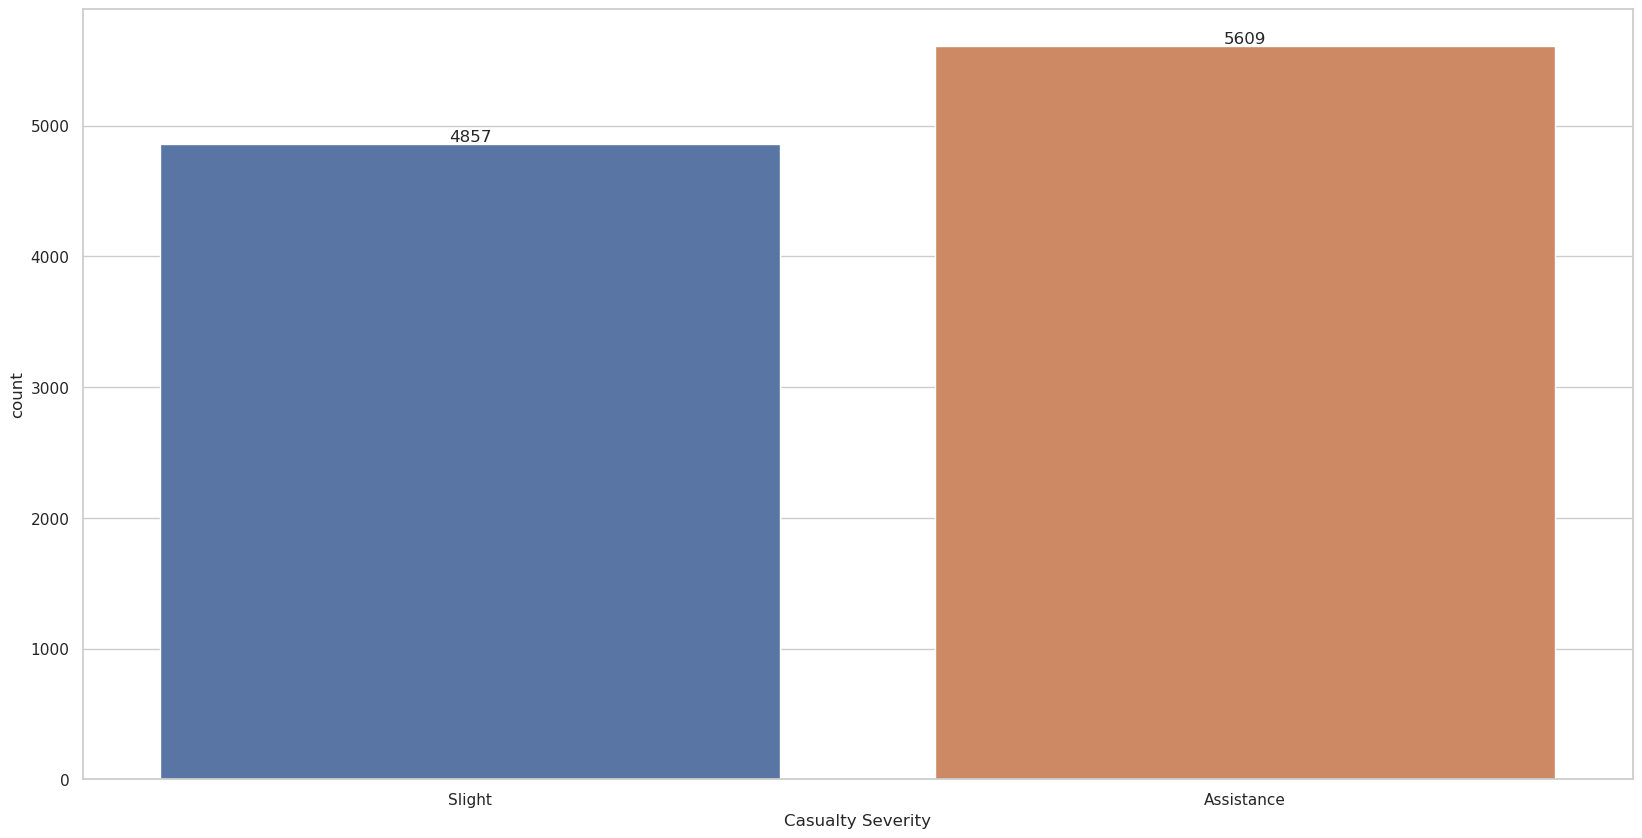

In [51]:
data_type = 'original'
save_histogram(city_name, data_frame[target_class], data_type)

# TEST

## Filter areas

In [52]:
x_name = 'Easting'
y_name = 'Northing'

data_frame[x_name] = data_frame[x_name].astype(int)
data_frame[y_name] = data_frame[y_name].astype(int)

casualty_name = 'Casualty Severity'
casualty_target_names = ['Assistance']

In [53]:
# 8
from src.data import remove_outliers

data_frame = remove_outliers(data_frame, x_name, y_name)

In [54]:
from src.data import get_intervals
from src.data import get_divisible_numbers

interval_x, interval_y = get_intervals(data_frame, x_name, y_name)

print('X')
get_divisible_numbers(interval_x)
print('Y')
get_divisible_numbers(interval_y)

X
Area units: 1, regions: 721601.0
Area units: 19, regions: 37979.0
Area units: 163, regions: 4427.0
Area units: 233, regions: 3097.0
Area units: 3097, regions: 233.0
Area units: 4427, regions: 163.0
Area units: 37979, regions: 19.0
Y
Area units: 1, regions: 510158.0
Area units: 2, regions: 255079.0
Area units: 11, regions: 46378.0
Area units: 22, regions: 23189.0
Area units: 23189, regions: 22.0
Area units: 46378, regions: 11.0
Area units: 255079, regions: 2.0


In [55]:
filename_to_load = f'{city_name}_victoria.csv'

In [61]:
from src.data import get_rows_by_removing_areas

# Birmingan
# x_offset = 211
# y_offset = 75

# Cornwall (UK)
# x_offset = 10
# y_offset = 8

# Southwark
# x_offset = 10 -> regions: 529
# y_offset = 20 -> regions: 487

# Tower
# 6 times remove feaures
# x_offset = 19, regions: 307.0
# y_offset = 25, regions: 246.0

x_offset = 145
y_offset = 97
new_dataframe = get_rows_by_removing_areas(data_frame,
                                           x_name = x_name,
                                           y_name = y_name,
                                           x_offset = x_offset,
                                           y_offset = y_offset,
                                           casualty_name = casualty_name,
                                           casualty_target_names = casualty_target_names)
new_dataframe.to_csv(filename_to_load)

100%|████████████████████████████████████████████████████████████| 5241/5241 [13:42<00:00,  6.37it/s]


In [56]:
filename_to_load 

'Victoria_victoria.csv'

In [57]:
filename_to_load = f'{city_name}_victoria.csv'
new_dataframe = pd.read_csv(filename_to_load, index_col=0)
new_dataframe_2 = new_dataframe
data_frame = new_dataframe_2.loc[:, ~new_dataframe_2.columns.isin(['longitude', 'latitude'])]

# new_dataframe.to_csv('test_uk.csv')

## Plot accidents

In [58]:
# # new_dataframe_2 = new_dataframe[new_dataframe['Casualty Severity'] == 'Assistance']
# from src.maps import plot_map

# latitude_name  = 'latitude'
# longitude_name = 'longitude'

# new_dataframe_2 = new_dataframe

# plot_map(new_dataframe_2,
#          latitude_name = latitude_name,
#          longitude_name = longitude_name,
#          color_by = casualty_name)


# END TEST

## Filtered Histogram

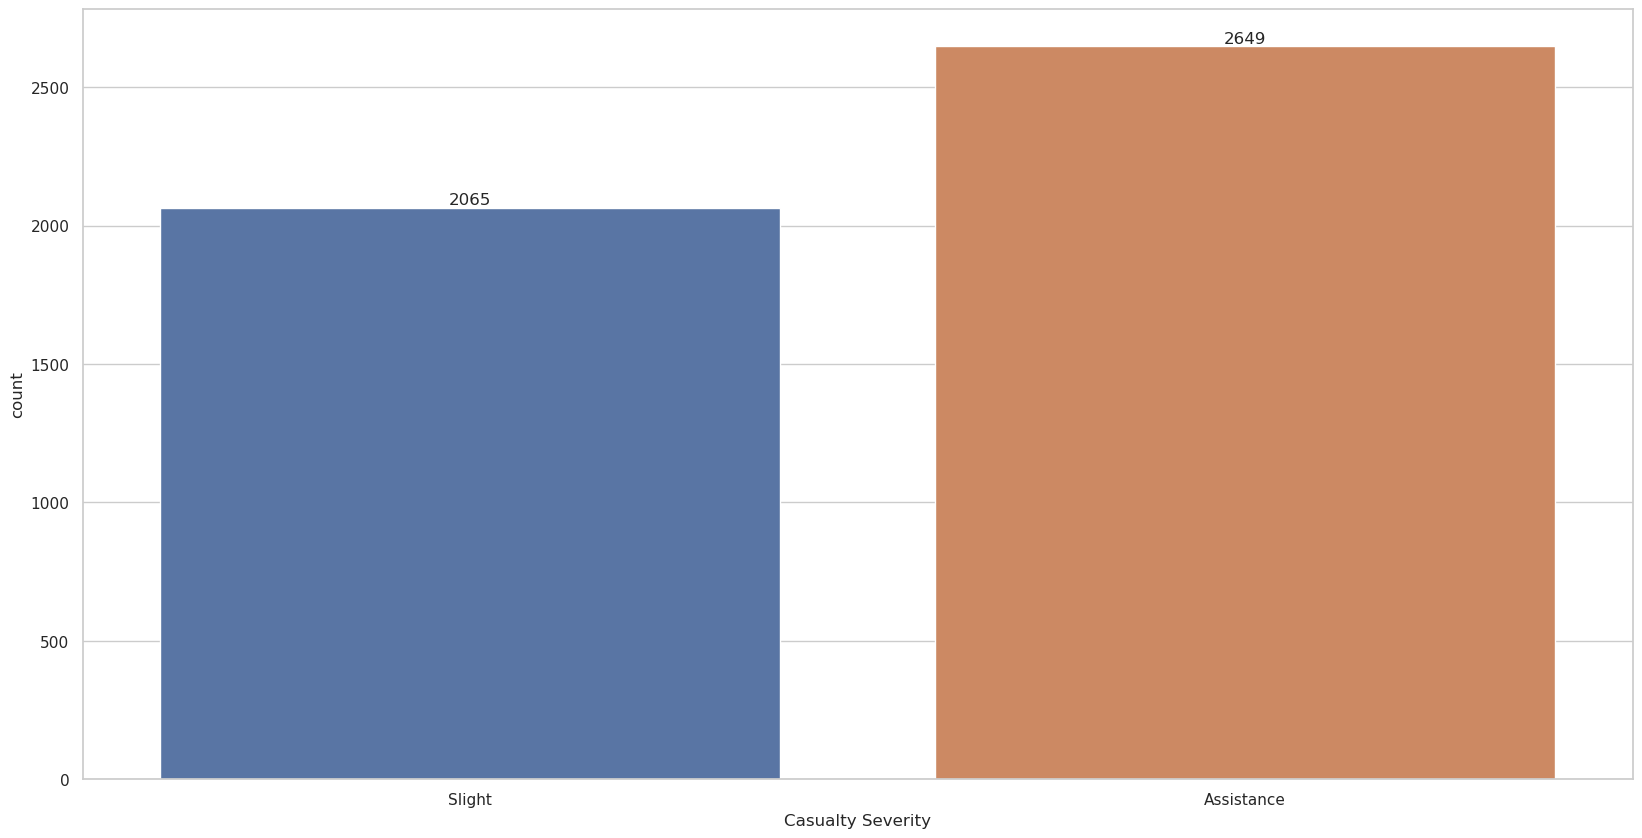

In [59]:
data_type = 'filtered'
save_histogram(city_name, data_frame[target_class], data_type)

## Split de datos

In [60]:
data_frame = data_frame.loc[:, ~data_frame.columns.isin(['Latitude', 'Longitude'])]
data_frame

,Easting,Northing,1st Road Class,Number of Vehicles,Road Surface,Speed Limit,Lighting Conditions,Weather Conditions,dia_semana,semana_en_año,Type of Vehicle,Age of Vehicle,First Point of Impact,Casualty Class,Sex of Casualty,Age of Casualty,Casualty Severity,Accident Time Sin,Accident Time Cos
4014,2579282,2302242,0,1,1,100,1,1,2,48,4,2005,6,2,0,3,Assistance,-8.870108e-01,-0.461749
4041,2593424,2304909,0,2,1,100,1,1,7,47,1,1998,4,3,0,3,Slight,3.826834e-01,-0.923880
4042,2593424,2304909,0,2,1,100,1,1,7,47,1,1998,4,3,1,2,Assistance,3.826834e-01,-0.923880
4043,2593424,2304909,0,2,1,100,1,1,7,47,1,1998,4,2,0,2,Slight,3.826834e-01,-0.923880
5848,2385725,2306720,0,1,1,80,9,1,5,50,2,1995,4,2,0,2,Assistance,-4.361939e-02,0.999048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10434,2236475,2808547,4,3,1,50,3,1,3,46,10,1988,1,2,0,2,Slight,-6.755902e-01,0.737277
10435,2236475,2808547,4,3,1,50,3,1,3,46,2,1988,1,2,0,2,Slight,-6.755902e-01,0.737277
5792,2229170,2809734,0,1,1,60,5,1,3,51,1,1991,4,3,0,1,Assistance,9.659258e-01,0.258819
5793,2229170,2809734,0,1,1,60,5,1,3,51,1,1991,4,2,1,1,Assistance,9.659258e-01,0.258819


In [61]:
from sklearn.model_selection import train_test_split

Y = data_frame[target_class]

train, test = train_test_split(data_frame, test_size = 0.3)
X_train = X_train_original = train.loc[:, ~train.columns.isin([target_class])]
Y_train = Y_train_original = train[target_class]

X_test = test.loc[:, ~test.columns.isin([target_class])]
Y_test = test[target_class]

### Downsampling

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

slight_data  = train[train[target_class] == 'Slight']
serious_data = train[train[target_class] == 'Serious']
fatal_data   = train[train[target_class] == 'Fatal']

X_slight_downsampled  = resample(slight_data,
                                 replace = True,
                                 n_samples = len(fatal_data))

X_serious_downsampled = resample(serious_data,
                                 replace = True,
                                 n_samples = len(fatal_data))

downsampled_dataset = pd.concat([X_slight_downsampled, X_serious_downsampled, fatal_data])

# downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)

X_train_downsampled = downsampled_dataset.loc[:, ~downsampled_dataset.columns.isin([target_class])]
Y_train_downsampled = downsampled_dataset[target_class]

# X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin([target_class])]
# Y_test_downsampled = downsampled_test[target_class]

### Downsampled Histogram

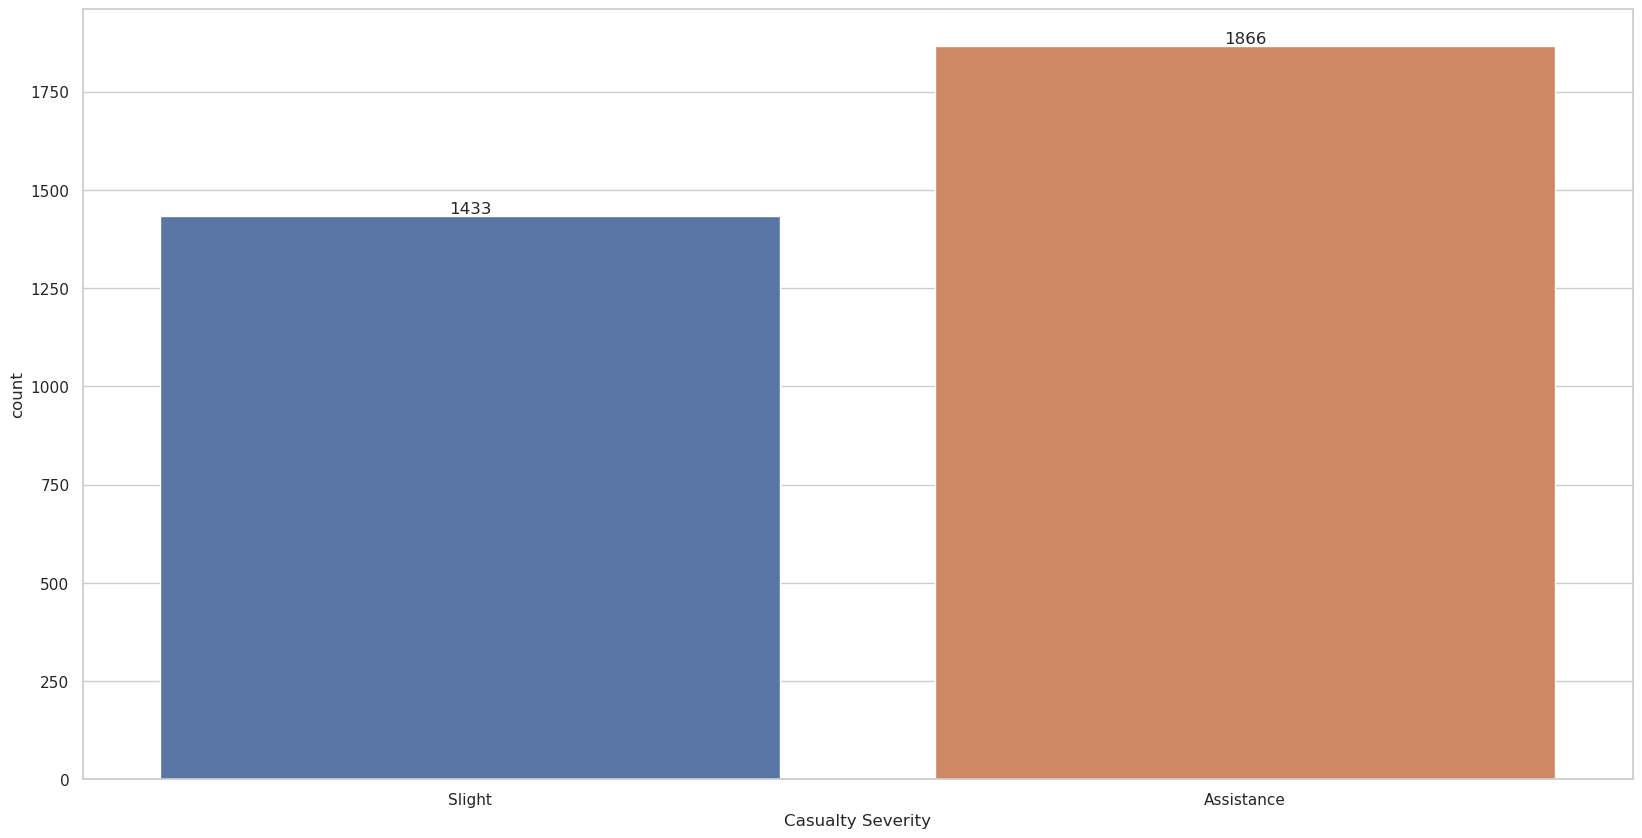

In [63]:
data_type = 'downsampled_train'
save_histogram(city_name, Y_train, data_type)

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
city = True
if city:
    slight_data  = train[train[target_class] == 'Slight']
    assistance_data = train[train[target_class] == 'Assistance']

    X_slight_downsampled  = resample(slight_data,
                                     replace = True,
                                     n_samples = len(assistance_data))


    downsampled_dataset = pd.concat([X_slight_downsampled, assistance_data])

    # downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)


    X_train_downsampled = downsampled_dataset.loc[:, ~downsampled_dataset.columns.isin([target_class])]
    Y_train_downsampled = downsampled_dataset[target_class]

    # X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin([target_class])]
    # Y_test_downsampled = downsampled_test[target_class]

In [65]:
# fv2gi(feature_vector)
# sorted(feature_vector.items(), key = lambda item: item[0][1])

# for item in feature_vector['Accident Features'].items():
#     print(item[1])

# feature_vector[parent_key].items()

# sorted(feature_vector['Accident Features'].items(), key = lambda item: item,
#                                reverse = True)

# print(feature_vector['Accident Features']['feature_weights'])

# fv = np.array(feature_vector['Accident Features']['feature_childs'])
# list(fv[indexes])

## Normalización de datos

In [66]:
# !conda install -c conda-forge imbalanced-learn

In [67]:
data_frame

,Easting,Northing,1st Road Class,Number of Vehicles,Road Surface,Speed Limit,Lighting Conditions,Weather Conditions,dia_semana,semana_en_año,Type of Vehicle,Age of Vehicle,First Point of Impact,Casualty Class,Sex of Casualty,Age of Casualty,Casualty Severity,Accident Time Sin,Accident Time Cos
4014,2579282,2302242,0,1,1,100,1,1,2,48,4,2005,6,2,0,3,Assistance,-8.870108e-01,-0.461749
4041,2593424,2304909,0,2,1,100,1,1,7,47,1,1998,4,3,0,3,Slight,3.826834e-01,-0.923880
4042,2593424,2304909,0,2,1,100,1,1,7,47,1,1998,4,3,1,2,Assistance,3.826834e-01,-0.923880
4043,2593424,2304909,0,2,1,100,1,1,7,47,1,1998,4,2,0,2,Slight,3.826834e-01,-0.923880
5848,2385725,2306720,0,1,1,80,9,1,5,50,2,1995,4,2,0,2,Assistance,-4.361939e-02,0.999048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10434,2236475,2808547,4,3,1,50,3,1,3,46,10,1988,1,2,0,2,Slight,-6.755902e-01,0.737277
10435,2236475,2808547,4,3,1,50,3,1,3,46,2,1988,1,2,0,2,Slight,-6.755902e-01,0.737277
5792,2229170,2809734,0,1,1,60,5,1,3,51,1,1991,4,3,0,1,Assistance,9.659258e-01,0.258819
5793,2229170,2809734,0,1,1,60,5,1,3,51,1,1991,4,2,1,1,Assistance,9.659258e-01,0.258819


In [68]:
if city:

    # X_test_downsampled  = X_test_downsampled.astype(int)

    X_train = normalize_data(X_train)
    X_test  = normalize_data(X_test)
    X_train_downsampled = normalize_data(X_train_downsampled)
    # X_test_downsampled  = normalize_data(X_test_downsampled)

    X_train_original = normalize_data(X_train_original)

/tmp/ipykernel_3862820/4039655262.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df[column] = zscore(normalized_df[column])


## Oversamplig de datos

In [69]:
# print('********** Train Before OverSampling **********')
# print('Slight: ', (Y_train == 'Slight').sum())
# print('Serious:', (Y_train == 'Serious').sum())
# print('Fatal:  ', (Y_train == 'Fatal').sum())
# print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

# X_train, Y_train = oversample_data(X_train, Y_train)

# print('********** Test **********')
# print('Slight: ', (Y_test == 'Slight').sum())
# print('Serious:', (Y_test == 'Serious').sum())
# print('Fatal:  ', (Y_test == 'Fatal').sum())
# print('\n Total X:', len(Y_test), ' Total Y:', len(Y_test), '\n')

In [70]:
if city:
    print('********** Train Before OverSampling **********')
    print('Slight: ', (Y_train == 'Slight').sum())
    print('Assistance:  ', (Y_train == 'Assistance').sum())
    print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

    X_train, Y_train = oversample_data(X_train, Y_train)

    print('********** Test **********')
    print('Slight: ', (Y_test == 'Slight').sum())
    print('Assistance:  ', (Y_test == 'Assistance').sum())
    print('\n Total X:', len(Y_test), ' Total Y:', len(Y_test), '\n')

********** Train Before OverSampling **********
Slight:  1433
Assistance:   1866

 Total X: 3299  Total Y: 3299 

********** After OverSampling **********
Slight:  1865
Assistance: 1866

 Total X:  3731  Total Y:  3731 

********** Test **********
Slight:  632
Assistance:   783

 Total X: 1415  Total Y: 1415 



### OVersampled Histogram

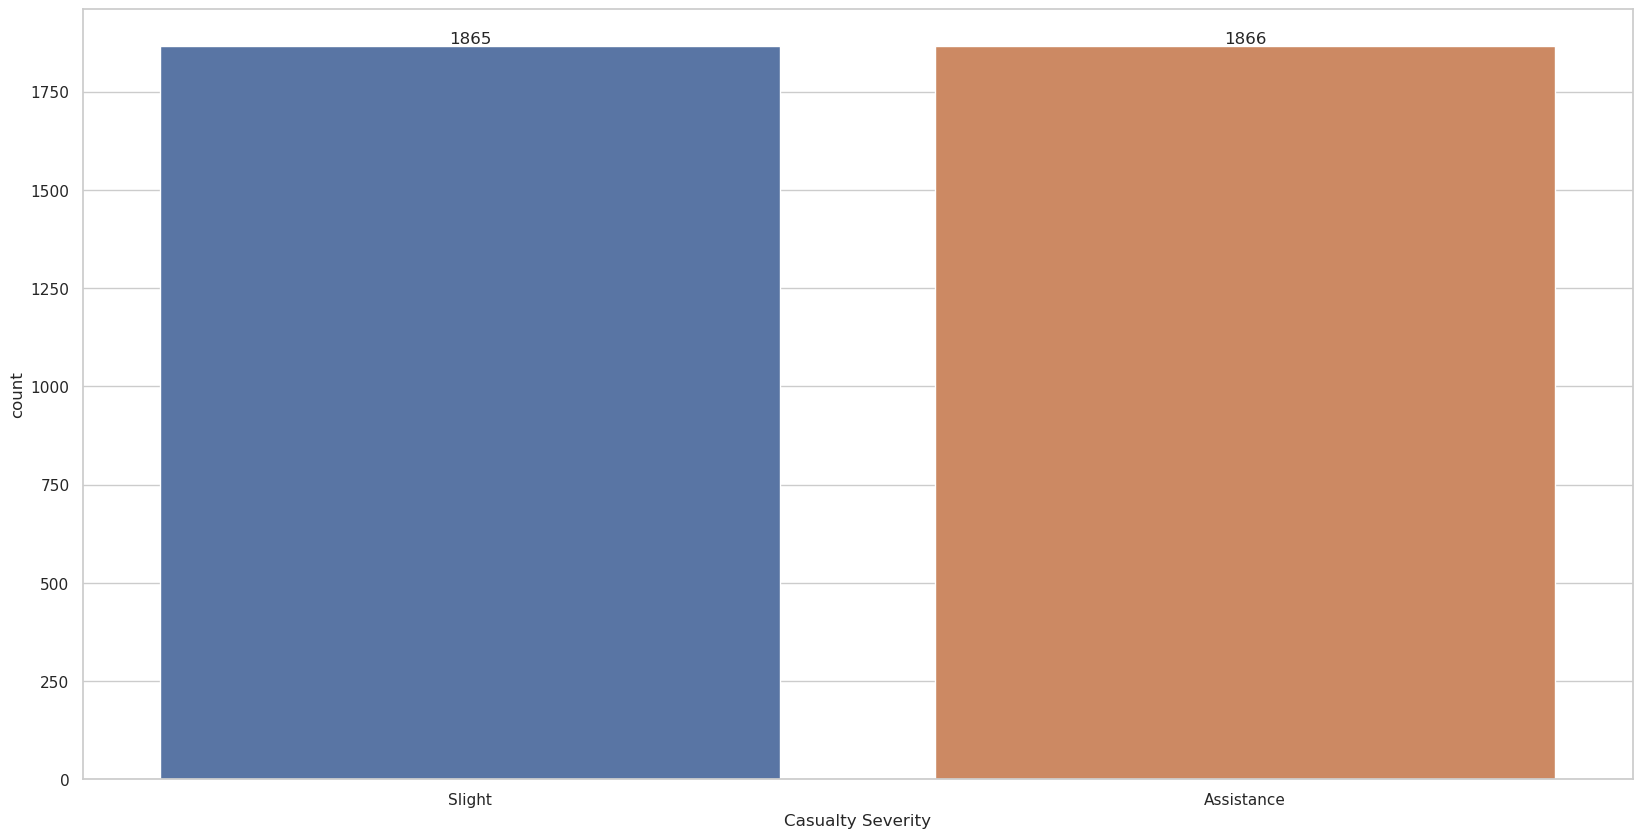

In [71]:
data_type = 'oversampled_train'
save_histogram(city_name, Y_train, data_type)

## XGBoost

In [72]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Genético

In [73]:
data_frame['Casualty Severity']

4014     Assistance
4041         Slight
4042     Assistance
4043         Slight
5848     Assistance
            ...    
10434        Slight
10435        Slight
5792     Assistance
5793     Assistance
6721     Assistance
Name: Casualty Severity, Length: 4714, dtype: object

In [74]:
if city:
    casualty_to_one_hot(Y_train)
    Y_train

In [79]:
# SEVERITY_TYPE_REPLACE = {'Slight': 0,
#                          'Assistance': 1
#                         }

# Y_train.replace(SEVERITY_TYPE_REPLACE, inplace = True)
# Y_train_downsampled.replace(SEVERITY_TYPE_REPLACE, inplace = True)
# Y_test.replace(SEVERITY_TYPE_REPLACE, inplace = True)

In [80]:
import xgboost as xgb
import random

if city and calculate_weights:
    casualty_to_one_hot(Y_train)
    casualty_to_one_hot(Y_train_downsampled)
    casualty_to_one_hot(Y_test)

    populationSize = (number_of_individuals, number_of_hyperparams)
    population = initialize_population(number_of_individuals   = number_of_individuals,
                                       hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

    fitnessHistory = np.empty([number_of_generations+1, number_of_individuals]) # Define an array to store the value of each parameter for each parent and generation
    populationHistory = np.empty([(number_of_generations+1)*number_of_individuals, number_of_hyperparams]) # Insert the value of initial parameters in history

    best_solution_history = np.empty([(number_of_generations), number_of_hyperparams+1])
    populationHistory[0:number_of_individuals,:] = population

    dtrain = xgb.DMatrix(data  = X_train_downsampled,
                         label = Y_train_downsampled)

    dtest  = xgb.DMatrix(data  = X_test, 
                         label = Y_test)

    for generation in range(number_of_generations):

        print("This is number %s generation" % (generation))

        new_population = []

        unique_individuals = np.unique(population, axis=0)

        new_individuals_to_create = number_of_individuals - len(unique_individuals)

        for i in range(new_individuals_to_create):
            new_individual = generate_individual(hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)
            new_population.append(new_individual)

        new_population = np.array(new_population)

        if (new_individuals_to_create):
            population = np.concatenate((unique_individuals, new_population), axis=0)

        # print(f'Current population is {population}')
        print(f'New population is {len(new_population)}')

        # Train the dataset and obtain fitness
        fitnessValue = train_population(population = population,
                                        hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                                        dMatrixTrain = dtrain,
                                        dMatrixTest = dtest,
                                        Y_test = Y_test)

        fitnessHistory[generation,:] = fitnessValue

        # Best score in the current iteration
        max_score_index = np.argmax(fitnessHistory[generation,:])
        max_score_value = np.max(fitnessHistory[generation,:])
        max_score_solution = population[max_score_index]

        max_solution_with_score = []
        max_solution_with_score = np.append(max_score_solution, max_score_value)
        best_solution_history[generation] = max_solution_with_score

        print(f"Best F1 score in the this iteration = {max_score_value}, best solution {max_score_solution}") # Survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected

        parents = new_parents_selection(population = population,
                                        fitness = fitnessValue,
                                        numParents = numberOfParentsMating)

        # Mate these parents to create children having parameters from these parents (we are using uniform crossover)
        children = crossover_uniform(parents = parents,
                                     childrenSize = (populationSize[0] - parents.shape[0], number_of_hyperparams))

        # Add mutation to create genetic diversity
        children_mutated = mutation(children,
                                    hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

        '''
        We will create new population, which will contain parents that where selected previously based on the
        fitness score and rest of them  will be children
        '''
        population[0:parents.shape[0], :] = parents # Fittest parents
        population[parents.shape[0]:, :]  = children_mutated # Children

        populationHistory[(generation+1)*number_of_individuals : (generation+1)*number_of_individuals + number_of_individuals , :] = population # Store parent information

    #Best solution from the final iteration

    fitness = train_population(population = population,
                               hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                               dMatrixTrain = dtrain,
                               dMatrixTest = dtest,
                               Y_test = Y_test)

    fitnessHistory[generation+1, :] = fitness # index of the best solution
    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]


    best_hyperparams = {}
    for n_param, hyperparam in enumerate(HYPERPARAMS_TO_OPTIMIZE):
        best_hyperparams[hyperparam] = population[bestFitnessIndex][n_param]

This is number 0 generation
New population is 0
Best F1 score in the this iteration = 0.7166, best solution [ 0.63 24.    3.4 ]
This is number 1 generation
New population is 11
Best F1 score in the this iteration = 0.73, best solution [ 0.76 16.    0.  ]
This is number 2 generation
New population is 11
Best F1 score in the this iteration = 0.73, best solution [ 0.76 16.    0.  ]
This is number 3 generation
New population is 21
Best F1 score in the this iteration = 0.7314, best solution [ 0.76 24.    0.  ]
This is number 4 generation
New population is 23
Best F1 score in the this iteration = 0.7329, best solution [ 0.76 23.    0.  ]
This is number 5 generation
New population is 19
Best F1 score in the this iteration = 0.7343, best solution [ 0.77 17.    0.  ]
This is number 6 generation
New population is 18
Best F1 score in the this iteration = 0.7357, best solution [ 0.76 17.    0.  ]
This is number 7 generation
New population is 22
Best F1 score in the this iteration = 0.7364, best so

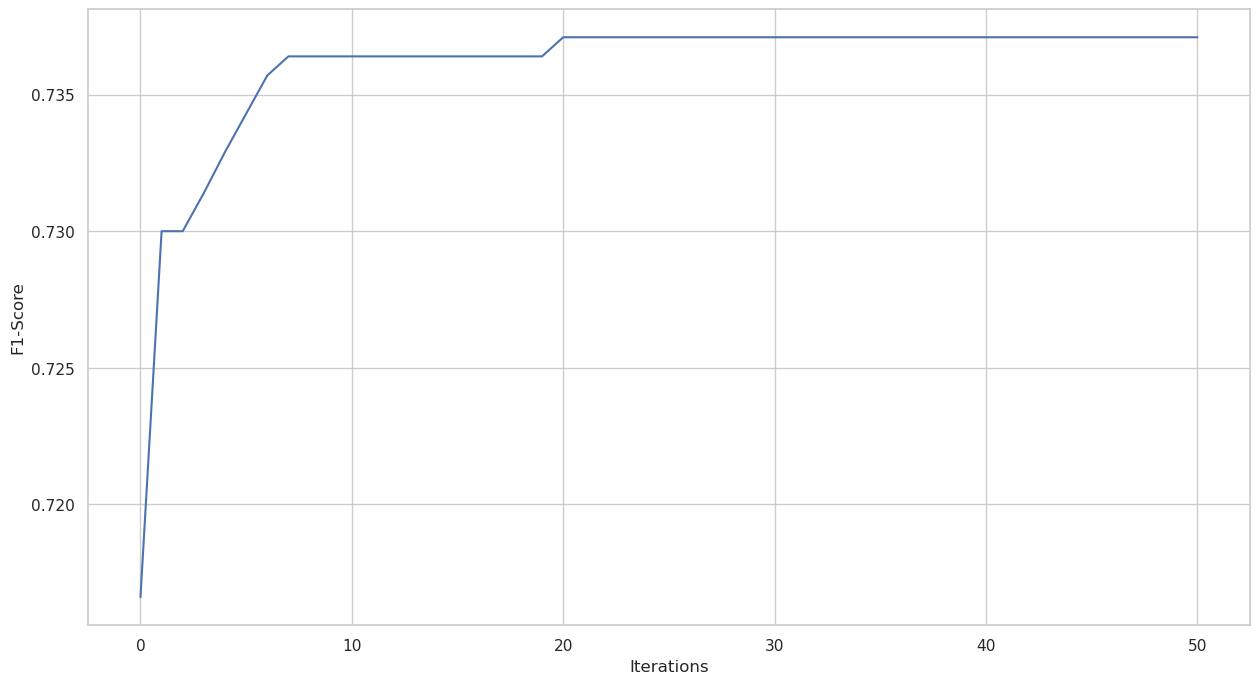

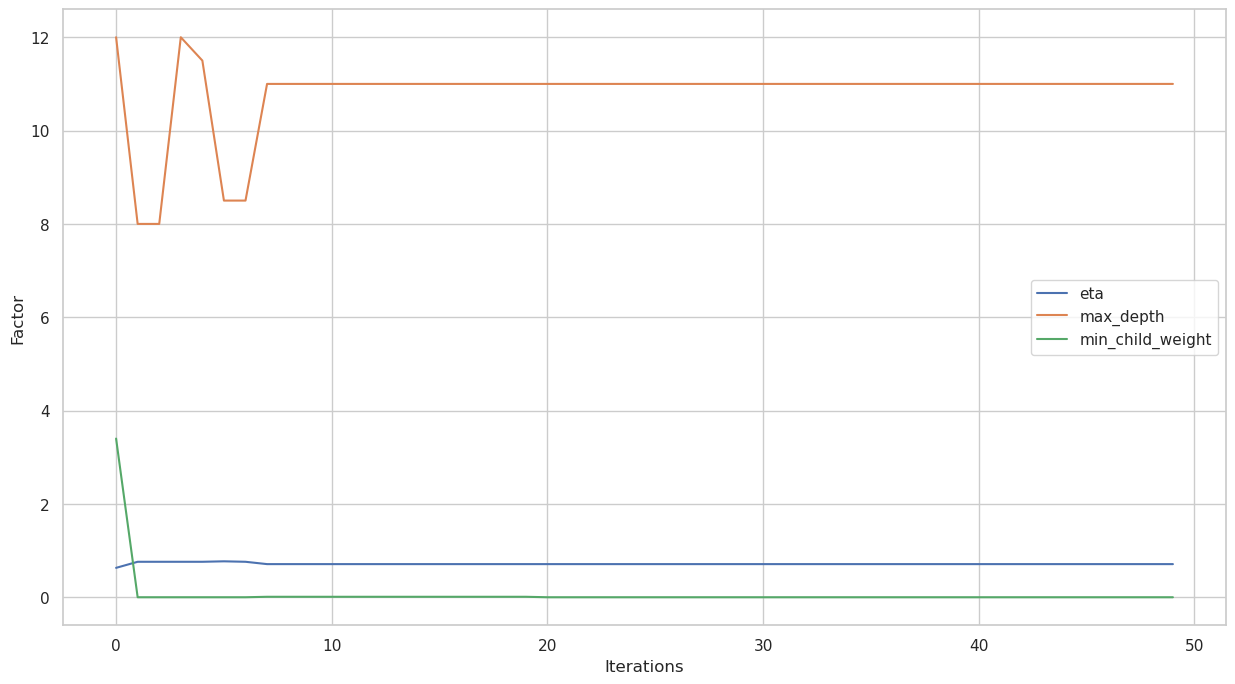

In [81]:
if calculate_weights and city:
    #### PLOT FITNESS EVOLUTION ####
    x_fitness = [np.max(fitnessHistory[i]) for i in range(0,fitnessHistory.shape[0])]

    FILE_NAME = f"{city_name}_ga_{MODEL_TIMESTAMP}.svg"

    plt.figure(figsize=(15, 8))
    plt.ylabel('F1-Score')
    plt.xlabel('Iterations')
    plt.plot(np.arange(len(x_fitness)), x_fitness)
    plt.savefig(GA_SCORES_PATH + FILE_NAME)

    #### PLOT HYPERPARAMS EVOLUTION ####
    FILE_NAME = f"{city_name}_ga_hyperparams_evolution_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.svg"

    LEGEND_LABELS = HYPERPARAMS_TO_OPTIMIZE.keys()

    plt.figure(figsize=(15, 8))
    best_solution_history_aux = best_solution_history
    best_solution_history_aux[:,1] = best_solution_history[:,1]/2
    best_solution_history_aux[:,3] = best_solution_history[:,3]/100
    plt.plot(best_solution_history_aux[:,:3])
    plt.ylabel('Factor')
    plt.xlabel('Iterations')
    plt.legend(LEGEND_LABELS)
    plt.savefig(HYPERPARAMS_EVOLUTON_PATH + FILE_NAME, dpi=300)

    FILE_NAME = f"{city_name}_population_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.txt"

    np.savetxt(FINAL_POPULATION_PATH + FILE_NAME, population, fmt='%s')

### Hiperparámetros

#### Carga hiperparámetros

In [82]:
if city and not calculate_weights:
    FILE_NAME = f"{city_name}_hyperparams{loaded_timestamp}.json"

    best_hyperparams = load_json(f"{HYPERPARAMS_PATH}{city_name}/", FILE_NAME)

# # # 0.04 2 6.5 --> 0.778
# best_hyperparams = {}
# best_hyperparams['eta'] = 0.1
# best_hyperparams['max_depth'] = 2
# best_hyperparams['min_child_weight'] = 1
# best_hyperparams['n_estimators'] = 583

# 1.00e-01 2.00e+00 1.00e+00 5.83e+02 --> 0.72

#### Cálculo de Hiperparámetros

In [83]:
# Y_train_onehot = casualty_to_one_hot(Y_train)
# Y_test_onehot  = casualty_to_one_hot(Y_test)

# space={'max_depth': hp.quniform("max_depth", 3, 25, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 15, 1),
#         'n_estimators': hp.quniform('n_estimators', 100, 4000, 100),
#         'tree_method': 'gpu_hist'
#     }

# def objective(space):
#     clf = XGBClassifier(n_estimators = int(space['n_estimators']),
#                         max_depth = int(space['max_depth']),
#                         gamma = space['gamma'],
#                         reg_alpha = int(space['reg_alpha']),
#                         min_child_weight = int(space['min_child_weight']),
#                         colsample_bytree = int(space['colsample_bytree']),
#                         tree_method = space['tree_method']
#                        )
    
#     evaluation = [(X_train, Y_train), (X_test, Y_test)]
    
#     clf.fit(X_train, Y_train,
#             eval_set = evaluation, eval_metric = "auc",
#             early_stopping_rounds = 10, verbose = False)
            
    
#     pred = clf.predict(X_test)
#     accuracy = accuracy_score(Y_test, pred>0.5)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }


# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

#### Escritura hiperparámetros

In [84]:
if calculate_weights and city:
    os.makedirs(f"{HYPERPARAMS_PATH}{city_name}", exist_ok=True)
    FILE_NAME = f"{city_name}_hyperparams{MODEL_TIMESTAMP}.json"

    write_json(best_hyperparams, f"{HYPERPARAMS_PATH}{city_name}/", FILE_NAME)

    print(best_hyperparams)

{'eta': 0.71, 'max_depth': 22.0, 'min_child_weight': 0.0}


### Pesos de características

#### Carga definitiva/auxiliar de pesos

In [85]:
# best_hyperparams['objective'] = 'binary:logistic'
# best_hyperparams.pop('objective')
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])

In [86]:
# '2022-07-06-10:47:41'

#### Cálculo de pesos de caracetrísticas

In [87]:
import xgboost as xgb
import random

if calculate_weights and city:
    casualty_to_one_hot(Y_train)
    FILE_NAME = f"Liverpool_weights_paper-iii.json"
    
    feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)
    xgboost = XGBClassifier(obj = 'binary:logistic',
                            **best_hyperparams,
                           
                            tree_method = tree_method,
                            single_precision_histogram =  True)

    xgboost.fit(X_train, Y_train)

    child_weights  = np.array(xgboost.feature_importances_)
    feature_vector = fill_feature_vector(X_train, child_weights)


#### Visualización pesos calculados

{'Easting': 14604.0, 'Northing': 6574.0, '1st Road Class': 2321.0, 'Number of Vehicles': 1849.0, 'Road Surface': 954.0, 'Speed Limit': 2219.0, 'Lighting Conditions': 849.0, 'Weather Conditions': 399.0, 'dia_semana': 2509.0, 'semana_en_año': 3221.0, 'Type of Vehicle': 3095.0, 'Age of Vehicle': 8460.0, 'First Point of Impact': 575.0, 'Casualty Class': 5954.0, 'Sex of Casualty': 4139.0, 'Age of Casualty': 6443.0, 'Accident Time Sin': 3714.0, 'Accident Time Cos': 2756.0}
Easting 0.024621295
Northing 0.04017323
1st Road Class 0.04499938
Number of Vehicles 0.062225025
Road Surface 0.030096479
Speed Limit 0.037650492
Lighting Conditions 0.05516498
Weather Conditions 0.070619084
dia_semana 0.045063585
semana_en_año 0.051302433
Type of Vehicle 0.017411655
Age of Vehicle 0.017676132
First Point of Impact 0.27868834
Casualty Class 0.05052915
Sex of Casualty 0.033257466
Age of Casualty 0.03354189
Accident Time Sin 0.04335166
Accident Time Cos 0.063627735


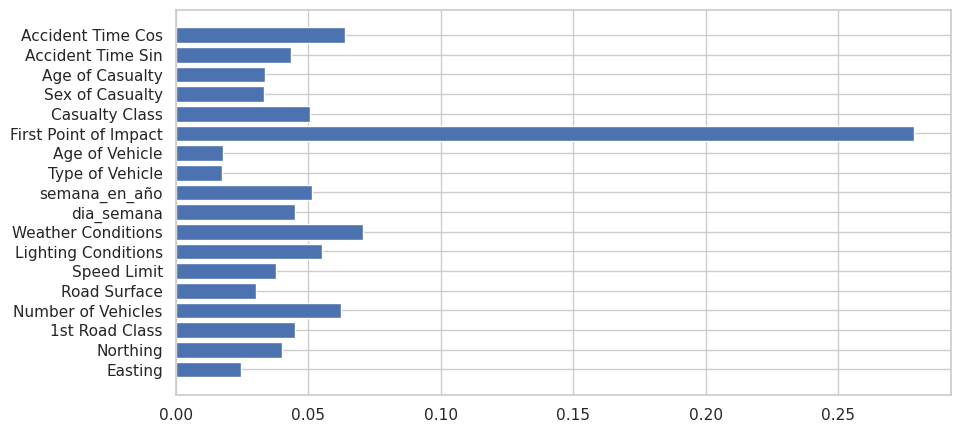

In [88]:
if calculate_weights and city:
    FILE_NAME = f"{city_name}_figure_weights_{MODEL_TIMESTAMP}.svg"

    print(xgboost.get_booster().get_score(importance_type= 'weight'))
    plt.figure(figsize=(10, 5))
    plt.barh(X_train.columns, xgboost.feature_importances_)
    plt.savefig(WEIGHTS_PATH + FILE_NAME)

    for column, weight in zip(X_train.columns,xgboost.feature_importances_):
      print(column, weight)

#### Escritura de pesos de características

In [89]:
if calculate_weights and city:    
    matrix_indexes = fv2gi(feature_vector)

    FILE_NAME = f"{city_name}_weights_{MODEL_TIMESTAMP}.json"
    # FILE_NAME = 'leeds_default_weights.json'

    write_json(feature_vector, WEIGHTS_PATH, FILE_NAME)
else:
    FILE_NAME = f"{city_name}_weights_paper-iii_{MODEL_TIMESTAMP}.json"
    
    feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)

### Cálculo índices de matriz

In [90]:
if city:
    c = fv2gi(feature_vector)

## Construcción de imágenes

In [91]:
if city:
    max_dimension_x = len(feature_vector.keys())
    max_dimension_y = get_max_child_numbers(feature_vector)
    train_bgi = build_gray_images(X_train, max_dimension_x, max_dimension_y, matrix_indexes)
    train_original_bgi = build_gray_images(X_train_original, max_dimension_x, max_dimension_y, matrix_indexes)

    test_bgi  = build_gray_images(X_test, max_dimension_x, max_dimension_y, matrix_indexes)


    pd.DataFrame(train_bgi[:,:,1057])

3731
3299
1415


## Reshape de imágenes

In [92]:
if city:
    train_images = shape_images(X_data = X_train,
                            gray_images = train_bgi)
    test_images  = shape_images(X_data = X_test,
                                gray_images = test_bgi)


    train_original_images = shape_images(X_data = X_train_original,
                                         gray_images = train_original_bgi)

In [93]:
feature_vector

{'Accident Features': {'feature_childs': ['Easting',
   'Northing',
   '1st Road Class',
   'Number of Vehicles'],
  'feature_weights': ['0.024621295',
   '0.04017323',
   '0.04499938',
   '0.062225025'],
  'wpi': 0.17201893000000001},
 'Roadway Features': {'feature_childs': ['Road Surface', 'Speed Limit'],
  'feature_weights': ['0.030096479', '0.037650492'],
  'wpi': 0.067746971},
 'Environmental Features': {'feature_childs': ['Lighting Conditions',
   'Weather Conditions'],
  'feature_weights': ['0.05516498', '0.070619084'],
  'wpi': 0.125784064},
 'Vehicle Features': {'feature_childs': ['Type of Vehicle',
   'Age of Vehicle',
   'First Point of Impact'],
  'feature_weights': ['0.017411655', '0.017676132', '0.27868834'],
  'wpi': 0.31377612699999996},
 'Time Features': {'feature_childs': ['Accident Time Sin',
   'Accident Time Cos',
   'dia_semana',
   'semana_en_año'],
  'feature_weights': ['0.04335166',
   '0.063627735',
   '0.045063585',
   '0.051302433'],
  'wpi': 0.203345413},
 

<Figure size 640x480 with 0 Axes>

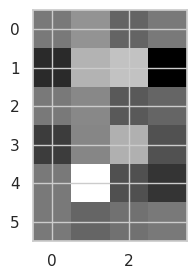

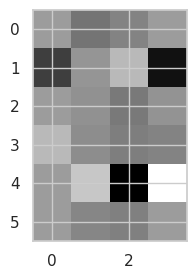

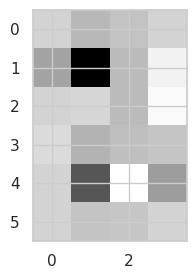

In [94]:
if city:
    plt.gray()
    for i in range(0,3):
        plt.figure(figsize=(3, 3))
        plt.imshow(train_bgi[:,:,i])
        # plt.savefig(f"{city_name}_image_example_{i}.svg",transparent=True)
        plt.show()

In [95]:
MODEL_TIMESTAMP

'2023-10-11-09:38:22'

In [96]:
# image = train_bgi[:,:,0]
# plt.figure(figsize=(6, 6))
# plt.imshow([image.flatten()])
# plt.savefig(f"test.svg",transparent=True, dpi=150)


In [97]:
# !conda install scikit-image

In [98]:
if city:
    # input_shape = (5, 5)

    array_train_images = np.asarray(train_images)
    array_test_images  = np.asarray(test_images)

    array_train_original_images = np.asarray(train_original_images)

In [99]:
# !conda install -c conda-forge tensorflow 

In [100]:
######### EN TERMINAL #########
# !pip install tensorflow-addons

## Visualización de datos

In [101]:
# !conda install seaborn

### Matriz de correlación

In [102]:
# correlation_matrix(X_test)

### PCA

In [103]:
# pca(X_train, X_test)

### TSNE

In [104]:
if city:
    n_samples = 150
    index_slight  = Y_train[Y_train == 'Slight'][:n_samples].index
    index_serious = Y_train[Y_train == 'Serious'][:n_samples].index
    index_fatal   = Y_train[Y_train == 'Fatal'][:n_samples].index

In [105]:
if city:
    # Get same number of class samples from SMOTEII
    X_slight_train_tsne  = X_train.loc[index_slight]
    X_serious_train_tsne = X_train.loc[index_serious]
    X_fatal_train_tsne   = X_train.loc[index_fatal]

    X_train_tsne = pd.concat([X_slight_train_tsne, X_serious_train_tsne, X_fatal_train_tsne])

    Y_slight_train_tsne  = Y_train[index_slight]
    Y_serious_train_tsne = Y_train[index_serious]
    Y_fatal_train_tsne   = Y_train[index_fatal]

    Y_train_tsne = pd.concat([Y_slight_train_tsne, Y_serious_train_tsne, Y_fatal_train_tsne])

In [106]:
if city:
    n_samples = len(Y_train_original[Y_train_original == 'Fatal'])

    index_slight  = Y_train_original[Y_train_original == 'Slight'][:n_samples].index
    index_serious = Y_train_original[Y_train_original == 'Serious'][:n_samples].index
    index_fatal   = Y_train_original[Y_train_original == 'Fatal'][:n_samples].index

In [107]:
if city:
    # Get same number of class samples from original
    X_slight_clean_tsne  = X_train_original.loc[index_slight]
    X_serious_clean_tsne = X_train_original.loc[index_serious]
    X_fatal_clean_tsne   = X_train_original.loc[index_fatal]

    X_clean_tsne = pd.concat([X_slight_clean_tsne, X_serious_clean_tsne, X_fatal_clean_tsne])

    Y_slight_clean_tsne  = Y_train_original[index_slight]
    Y_serious_clean_tsne = Y_train_original[index_serious]
    Y_fatal_clean_tsne   = Y_train_original[index_fatal]

    Y_clean_tsne = pd.concat([Y_slight_clean_tsne, Y_serious_clean_tsne, Y_fatal_clean_tsne])

In [108]:
if tsne and city:
    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras originales 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_test_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras originales 3 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_tsne_train_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_train_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 3 Componentes')

### Autoencoder

#### Entrenamiento

In [109]:
# X_train = array_train_images
# X_test = array_test_images
# X_train_original = array_train_original_images

# X_train = X_train.reshape(len(array_train_images), 25)
# X_train_original = X_train_original.reshape(len(array_train_original_images), 25)
# X_test  = X_test.reshape(len(X_test), 25)

# autoencoder = autoencoder().fit(X_train, X_train,
#                                 epochs = 100,
#                                 batch_size = 128,
#                                 shuffle = True,
#                                 validation_data = (X_test, X_test))

#### Visualización

In [110]:
# # create encoder model
# encoder = Model(inputs=input_img, outputs=encoder2)
# encoder.summary()
# # create decoder model
# encoded_input = Input(shape=(3,))
# #lo que hace aqui es quedarse con las capas que corresponden al decodificador
# decoder_layer1 = autoencoder.layers[-2]
# decoder_layer2 = autoencoder.layers[-1]
# decoder = Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))
# decoder.summary()
# # si miramos la salida, son simetricos el uno respecto al otro
# # encoder va de input a 3 y decoder de 3 a input

# # get latent vector for visualization
# latent_vector = encoder.predict(X_test)
# # # get decoder output to visualize reconstructed image
# # reconstructed_imgs = decoder.predict(latent_vector)


# # visualize in 3D plot
# from pylab import rcParams
# from mpl_toolkits.mplot3d import Axes3D

# rcParams['figure.figsize'] = 10, 8

# fig = plt.figure(1)
# ax = Axes3D(fig)

# xs = latent_vector[:, 0]
# ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# color=['red','green','blue']

# for x, y, z, label in zip(xs, ys, zs, Y_test):
#     c = color[int(label)]
#     ax.text(x, y, z, label, backgroundcolor=c)
    
# ax.set_xlim(xs.min(), xs.max())
# ax.set_ylim(ys.min(), ys.max())
# ax.set_zlim(zs.min(), zs.max())

# plt.show()

# # X_test_encoded = encoder.predict(X_test, batch_size=32)
# # plt.figure(figsize=(6, 6))
# # plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# # plt.colorbar()
# # plt.show()

## One-Hot

In [111]:
if city:
    Y_train_onehot = casualty_to_one_hot(Y_train)
    Y_train_original_onehot = casualty_to_one_hot(Y_train_original)
    Y_test_onehot  = casualty_to_one_hot(Y_test)

## Models

In [112]:
if city:
    array_train_images = np.asarray(train_images)
    # array_val_images   = np.asarray(val_images)
    array_test_images  = np.asarray(test_images)

    input_train_shape = (len(array_train_images), max_dimension_x, max_dimension_y, 1)
    # input_val_shape = (len(array_val_images), 5, 5, 1)
    input_test_shape  = (len(array_test_images), max_dimension_x, max_dimension_y, 1)

    array_train_images = array_train_images.reshape(input_train_shape)
    # array_val_images   = array_val_images.reshape(input_val_shape)
    array_test_images  = array_test_images.reshape(input_test_shape)

    Y_test_labels = one_hot_to_casualty(Y_test)

    from sklearn.utils import class_weight

    pesos = class_weight.compute_class_weight('balanced',
                                              classes = np.unique(Y_train_original),
                                              y = Y_train_original)


    print('\nPesos calculados:', pesos, '\n\n')


    # Keras espera un diccionario donde la clave sea el número de clase 
    # y el valor sea el peso calculado. 
    pesos = dict(enumerate(pesos))  


Pesos calculados: [1.15108165 0.88397642] 




In [113]:
import pickle
from joblib import dump, load

if city:
    times = pd.DataFrame()

### NB

In [114]:
MODEL_NAME = MODELS_NAME[0]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

sns.reset_defaults()

#### Entrenamiento

In [115]:
from sklearn.naive_bayes import GaussianNB

if city and train_nn and other_models:
    start = time.time()

    gnb = GaussianNB()
    gnb = gnb.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])


    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! nb in 0.0 (s)


#### Escritura del modelo

In [116]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(gnb, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [117]:
if city and not train_nn and other_models:

    gnb = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [118]:
if city and other_models:
    print("[INFO] evaluating model...")
    if train_nn:
        Y_train_predicted = gnb.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = gnb.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.536   0.788     0.638  1866.000
Slight            0.600   0.318     0.416  1865.000
accuracy          0.553   0.553     0.553     0.553
macro avg         0.568   0.553     0.527  3731.000
weighted avg      0.568   0.553     0.527  3731.000
              precision  recall  f1-score   support
Assistance        0.570   0.851     0.682   783.000
Slight            0.524   0.204     0.294   632.000
accuracy          0.562   0.562     0.562     0.562
macro avg         0.547   0.527     0.488  1415.000
weighted avg      0.549   0.562     0.509  1415.000


### SVC

In [119]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

MODEL_NAME = MODELS_NAME[1]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [120]:
if city and train_nn and other_models:
    start = time.time()

    clf = SVC(gamma='auto')
    clf.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! svc in 0.23 (s)


#### Escritura del modelo

In [121]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [122]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    clf = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [123]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = clf.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = clf.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.753   0.667     0.707  1866.000
Slight            0.701   0.782     0.739  1865.000
accuracy          0.724   0.724     0.724     0.724
macro avg         0.727   0.724     0.723  3731.000
weighted avg      0.727   0.724     0.723  3731.000
              precision  recall  f1-score   support
Assistance        0.730   0.633     0.679   783.000
Slight            0.610   0.710     0.656   632.000
accuracy          0.668   0.668     0.668     0.668
macro avg         0.670   0.672     0.667  1415.000
weighted avg      0.677   0.668     0.669  1415.000


### KNN

In [124]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

MODEL_NAME = MODELS_NAME[2]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

#### Entrenamiento

In [125]:
if city and train_nn and other_models:
    knn = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

    start = time.time()

    knn.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

# leaf_size = list(range(1,10, 2))
# n_neighbors = list(range(1,100, 10))
# p = [1, 2]

# if city and train_nn and other_models:

#     start = time.time()

#     # Create new KNN object
#     hyperparameters = dict(leaf_size = leaf_size,
#                            n_neighbors = n_neighbors)

#     # Use GridSearch
#     knn_2 = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

#     # Fit the model
#     clf = GridSearchCV(knn_2,
#                        hyperparameters,
#                        cv = 4)

#     knn = clf.fit(X_train, Y_train)

#     end = time.time()

#     ellapsed_time = round(end - start, 2)


#     model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
#     times = times.append(model_time)

#     # Print The value of best Hyperparameters

#     best_leaf_size  = knn.best_estimator_.get_params()['leaf_size']
#     best_n_neighbors = knn.best_estimator_.get_params()['n_neighbors']

#     print('Best leaf_size:', best_leaf_size)
#     print('Best n_neighbors:', best_n_neighbors)

#     df = pd.DataFrame({'best_leaf_size':[best_leaf_size], 'n_neighbors':[best_n_neighbors]})

#     FILE_NAME = f"{MODEL_NAME}/madrid_{MODEL_TIMESTAMP}.csv"

#     df.to_csv(HYPERPARAMS_PATH + FILE_NAME, index = True)

#### Escritura del modelo

In [126]:
if city and train_nn and other_models:

    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(knn, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [127]:
# if city and not train_nn and other_models:

#     version = 'X'
#     MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
#     MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{model_version}.joblib"

#     knn = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [128]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = knn.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = knn.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision  recall  f1-score   support
Assistance        0.661   0.503     0.571  1866.000
Slight            0.599   0.743     0.663  1865.000
accuracy          0.623   0.623     0.623     0.623
macro avg         0.630   0.623     0.617  3731.000
weighted avg      0.630   0.623     0.617  3731.000
              precision  recall  f1-score   support
Assistance        0.703   0.496     0.581   783.000
Slight            0.542   0.741     0.626   632.000
accuracy          0.605   0.605     0.605     0.605
macro avg         0.623   0.618     0.604  1415.000
weighted avg      0.631   0.605     0.601  1415.000


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Logistic Regression

In [129]:
from sklearn.linear_model import LogisticRegression

MODEL_NAME = MODELS_NAME[3]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [130]:
# train_nn = True

In [131]:
if city and train_nn and other_models:
    start = time.time()

    logistic_regression = LogisticRegression()  
    logistic_regression = logistic_regression.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! logistic_regression in 0.01 (s)


#### Escritura del modelo

In [132]:
if city and train_nn and other_models:

    os.makedirs(MODEL_PATH, exist_ok = True)
    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [133]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    logistic_regression = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [134]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_train_predicted = logistic_regression.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = logistic_regression.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score  support
Assistance        0.615   0.539     0.574   1866.0
Slight            0.589   0.662     0.623   1865.0
accuracy          0.600   0.600     0.600      0.6
macro avg         0.602   0.600     0.599   3731.0
weighted avg      0.602   0.600     0.599   3731.0
              precision  recall  f1-score   support
Assistance        0.669   0.536     0.595   783.000
Slight            0.539   0.671     0.598   632.000
accuracy          0.596   0.596     0.596     0.596
macro avg         0.604   0.604     0.596  1415.000
weighted avg      0.611   0.596     0.596  1415.000


### Random Forest

In [135]:
from sklearn.linear_model import LogisticRegression

MODEL_NAME = MODELS_NAME[4]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [136]:
if city and train_nn and other_models:
    start = time.time()

    xgboost = XGBClassifier()
    xgboost = XGBClassifier(n_estimators=2, max_depth=2, eta=0.01, min_child_weight= 6.8)
# "eta": 0.01, "max_depth": 2.0, "min_child_weight": 6.8}
    xgboost.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! random_forest in 0.09 (s)


#### Escritura del modelo

In [137]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [138]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    logistic_regression = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [139]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_train_predicted = xgboost.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = xgboost.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.891   0.232     0.368  1866.000
Slight            0.558   0.972     0.709  1865.000
accuracy          0.601   0.601     0.601     0.601
macro avg         0.724   0.602     0.538  3731.000
weighted avg      0.725   0.601     0.538  3731.000
              precision  recall  f1-score   support
Assistance        0.870   0.213     0.343   783.000
Slight            0.496   0.960     0.654   632.000
accuracy          0.547   0.547     0.547     0.547
macro avg         0.683   0.587     0.499  1415.000
weighted avg      0.703   0.547     0.482  1415.000


### MLP

In [140]:
from sklearn.neural_network import MLPClassifier

MODEL_NAME = MODELS_NAME[5]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [141]:
if city and train_nn and other_models:
    start = time.time()

    clf = MLPClassifier()

    clf.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! mlp in 2.23 (s)


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Escritura del modelo

In [142]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [143]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    clf = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [144]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_predicted = clf.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_predicted,
                                                         data = 'train')
    Y_predicted = clf.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.858   0.752     0.801  1866.000
Slight            0.779   0.875     0.824  1865.000
accuracy          0.813   0.813     0.813     0.813
macro avg         0.818   0.813     0.813  3731.000
weighted avg      0.818   0.813     0.813  3731.000
              precision  recall  f1-score   support
Assistance        0.738   0.660     0.697   783.000
Slight            0.627   0.709     0.666   632.000
accuracy          0.682   0.682     0.682     0.682
macro avg         0.682   0.685     0.681  1415.000
weighted avg      0.688   0.682     0.683  1415.000


### Convolution 1D

In [146]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [147]:
MODEL_NAME = MODELS_NAME[6]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

#### Entrenamiento

In [147]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [148]:
if city and train_nn and cnn1d and not calculate_cnn_hyperparams:
    
    fm_one, fm_two, fm_three, fm_four = (64, 512, 128, 256)
    n_classes = Y_train.unique()

    dense  = 256

    learnRate = 0.001

    batchSize = 64

    start = time.time()

    convolution_1d =  get_1d_conv(fm_one = fm_one,
                           fm_two = fm_two,
                           fm_three = fm_three,
                           fm_four = fm_four,
                           dense = dense,
                           dropout = 0.2,
                           learnRate = learnRate)

    history = convolution_1d.fit(array_train_images, Y_train_onehot,
                                   # class_weight = pesos,
                                   batch_size = batchSize,
                                   epochs = 50,
                                   shuffle = True,
                                   validation_data = (array_test_images, Y_test_onehot),
                                   callbacks=[tensorboard_callback])

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})

    times = pd.concat([times, model_time])

    history

Epoch 1/50


ValueError: in user code:

    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 5, 5, 1), found shape=(None, 6, 4, 1)


In [ ]:
# if city and train_nn and cnn1d and not calculate_cnn_hyperparams:
#     start = time.time()

#     fold_no = 1
#     # for train, test in kfold.split(inputs, targets):
#     history = convolution_1d.fit(array_train_images, Y_train_onehot,
#                                  # class_weight = pesos,
#                                  batch_size = 64,
#                                  epochs = 100,
#                                  shuffle = True,
#                                  validation_data = (array_test_images, Y_test_onehot))
#     end = time.time()

#     ellapsed_time = round(end - start, 2)

#     model_time = pd.DataFrame({'city': [city_name],
#                                'model': [MODEL_NAME],
#                                'time': [ellapsed_time]})

#     times = times.append(model_time)

#     history

In [ ]:
# if city and train_nn and not calculate_cnn_hyperparams:
    
#     fm_one, fm_two, fm_three, fm_four = (64, 512, 1024, 512)
#     n_classes = Y_train.unique()

#     dense  = 32

#     learnRate = 0.001

#     batchSize = 32

#     start = time.time()

#     convolution_1d = get_1d_conv(fm_one = fm_one,
#                            fm_two = fm_two,
#                            fm_three = fm_three,
#                            fm_four = fm_four,
#                            dense = dense,
#                            dropout = 0.2,
#                            learnRate = learnRate)

#     history = convolution_1d.fit(array_train_images, Y_train_onehot,
#                            # class_weight = pesos,
#                            batch_size = batchSize,
#                            epochs = 1,
#                            shuffle = True,
#                            validation_data = (array_test_images, Y_test_onehot))

#     end = time.time()

#     ellapsed_time = round(end - start, 2)

#     model_time = pd.DataFrame({'city': [city_name],
#                                'model': [MODEL_NAME],
#                                'time': [ellapsed_time]})
#     times = times.append(model_time)    

#     history

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
calculate_cnn_hyperparams=True
if city and train_nn and cnn1d and calculate_cnn_hyperparams:

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': 0})
    times = times.append(model_time)
    # wrap our model into a scikit-learn compatible classifier
    print("[INFO] initializing model...")
    model = KerasClassifier(build_fn=get_1d_conv, verbose=10)

    # define a grid of the hyperparameter search space

    # fm_one = fm_two = fm_three = fm_four = fm_five = fm_six = [32, 64, 128, 256, 512]
    fm_one = fm_two = fm_three = fm_four = [32, 64, 128, 256, 512, 1024]

    dense  = [32, 64, 128, 256]

    learnRate = [0.1, 1e-2, 1e-3, 1e-4]

    batchSize = [32, 64, 128]

    epochs = [60]

    # create a dictionary from the hyperparameter grid
    grid = dict(
        fm_one = fm_one,
        fm_two = fm_two,
        fm_three = fm_three,
        fm_four = fm_four,
        dense = dense,
        learnRate=learnRate,
        batch_size=batchSize,
        epochs=epochs
    )

    # initialize a random search with a 3-fold cross-validation and then
    # start the hyperparameter search process
    print("[INFO] performing random search...")
    searcher = RandomizedSearchCV(estimator = model,
                                  n_iter = 50,
                                  cv = 3,
                                  param_distributions = grid,
                                  scoring = 'f1_micro')

    searchResults = searcher.fit(array_train_images, Y_train)

    # summarize grid search information
    bestScore = searchResults.best_score_
    bestParams = searchResults.best_params_

    print("[INFO] best score is {:.2f} using {}".format(bestScore,	bestParams))

    print("[INFO] evaluating the best model...")
    convolution1d = bestModel = searchResults.best_estimator_
    # accuracy = bestModel.score(array_test_images, Y_test)
    # print("accuracy: {:.2f}%".format(accuracy * 100))

    text_file = open(f"./CNN1D-{MODEL_TIMESTAMP}.txt", "w")
    n = text_file.write(str(searchResults.cv_results_))
    text_file.close()

#### Escritura del modelo

In [ ]:
if city and train_nn and cnn1d:
    os.makedirs(MODEL_PATH, exist_ok = True)

    convolution_1d.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [ ]:
if city and not train_nn and not laptop and cnn1d:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{loaded_timestamp}.h5"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_2022-07-19-08:49:34.h5"
    # MODEL_FILE_NAME = 'madrid_convolution_1d_2022-05-19-06:33:55.h5'

    convolution_1d = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [ ]:
if city and cnn1d:

    print("[INFO] evaluating network...")

    Y_predicted = convolution_1d.predict(x = array_test_images).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

        plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
                              f1_score_name = F1_SCORE_NAME,
                              history = history)

        Y_train_predicted = convolution_1d.predict(x = array_train_images).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

### Convolution 2D

In [145]:
MODEL_NAME = MODELS_NAME[7]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

#### Entrenamiento

In [146]:

if city and cnn2d and not False:
    
    fm_one, fm_two, fm_three, fm_four = (256, 512, 256, 32)
    n_classes = Y_train.unique()

    dense  = 512

    learning_rate = 1e-05

    batchSize = 32

    start = time.time()

    tasp_cnn = get_tasp_cnn_o(max_dimension_x,
                              max_dimension_y,
                              fm_one = fm_one,
                              fm_two = fm_two,
                              fm_three = fm_three,
                              fm_four = fm_four,
                              dense = dense,
                              dropout = 0.2,
                              learning_rate = learning_rate)

    history = tasp_cnn.fit(array_train_images, Y_train_onehot,
                           # class_weight = pesos,
                           batch_size = batchSize,
                           epochs = 50,
                           shuffle = True,
                           validation_data = (array_test_images, Y_test_onehot))

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    history

Epoch 1/50


2023-10-11 09:48:36.693907: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


  1/117 [..............................] - ETA: 3:27 - loss: 0.9222 - f1_score: 0.6087

2023-10-11 09:48:37.083190: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-10-11 09:48:37.084052: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-10-11 09:48:37.084056: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-10-11 09:48:37.084083: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-10-11 09:48:37.159894: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] Tensor

117/117 [==============================] - 3s 9ms/step - loss: 0.7383 - f1_score: 0.6712 - val_loss: 0.7228 - val_f1_score: 0.6667
Epoch 2/50
117/117 [==============================] - 1s 7ms/step - loss: 0.5879 - f1_score: 0.7122 - val_loss: 0.7671 - val_f1_score: 0.6662
Epoch 3/50
117/117 [==============================] - 1s 5ms/step - loss: 0.5301 - f1_score: 0.7329 - val_loss: 0.7837 - val_f1_score: 0.6649
Epoch 4/50
117/117 [==============================] - 1s 8ms/step - loss: 0.4915 - f1_score: 0.7488 - val_loss: 0.7267 - val_f1_score: 0.6708
Epoch 5/50
117/117 [==============================] - 1s 7ms/step - loss: 0.4586 - f1_score: 0.7629 - val_loss: 0.6200 - val_f1_score: 0.6944
Epoch 6/50
117/117 [==============================] - 1s 8ms/step - loss: 0.4193 - f1_score: 0.7852 - val_loss: 0.5848 - val_f1_score: 0.7116
Epoch 7/50
117/117 [==============================] - 1s 9ms/step - loss: 0.3962 - f1_score: 0.7989 - val_loss: 0.5600 - val_f1_score: 0.7250
Epoch 8/50
117/11

In [147]:
with open(f'CNN2D_{MODEL_TIMESTAMP}.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [148]:
# from kerastuner import RandomSearch
# #creating randomsearch object
# tuner = RandomSearch(build_model,
#                      objective='val_accuracy',
#                      max_trials = 5)
# # search best parameter
# tuner.search(train_df,train_labl,epochs=3,validation_data=(train_df,train_labl))

In [149]:
X_train_singled = array_train_images.reshape((len(array_train_images), -1))
X_train_singled

array([[ 0.        ,  0.35320653, -0.27276242, ..., -0.25799236,
        -0.10012487,  0.        ],
       [ 0.        , -0.45654215, -0.27276242, ..., -0.25799236,
        -0.32184051,  0.        ],
       [ 0.        , -0.45654215, -0.27276242, ..., -0.25799236,
        -0.21098269,  0.        ],
       ...,
       [ 0.        , -0.45654215, -0.27276242, ..., -0.25799236,
        -0.01688747,  0.        ],
       [ 0.        , -0.28748204,  0.7946815 , ...,  1.05463536,
        -0.18783769,  0.        ],
       [ 0.        , -0.45654215, -0.27276242, ..., -0.25799236,
         0.04293547,  0.        ]])

https://www.google.com/search?channel=fs&client=ubuntu&q=gridsearch+sklearn+custom+validation


https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn


https://scikit-learn.org/stable/modules/cross_validation.html#predefined-fold-splits-validation-sets


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html#sklearn.model_selection.PredefinedSplit

In [150]:
from sklearn.preprocessing import OneHotEncoder

Y_train_array = np.asarray(Y_train)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = Y_train_array.reshape(len(Y_train_array), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
train_onehot_encoded = onehot_encoded.astype(int)

Y_test_array = np.asarray(Y_test)
integer_encoded = Y_test_array.reshape(len(Y_test_array), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
test_onehot_encoded = onehot_encoded.astype(int)

In [151]:
from sklearn.model_selection import PredefinedSplit

# -1 para train
# 0 para test
train_indexes = [-1] * array_train_images.shape[0]
test_indexes  = [0] * array_test_images.shape[0]

predefined_splitted_y_indexes = np.array(train_indexes + test_indexes)
predefined_splitted_x = np.concatenate((array_train_images, array_test_images), axis=0)
predefined_splitted_onehot = np.concatenate((train_onehot_encoded, test_onehot_encoded), axis=0)

ps = PredefinedSplit(predefined_splitted_y_indexes)

for i, (train_index, test_index) in enumerate(ps.split()):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 3728 3729 3730]
  Test:  index=[3731 3732 3733 ... 5143 5144 5145]


In [152]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

calculate_cnn_hyperparams=False
if city and cnn2d and calculate_cnn_hyperparams:

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': 0})

    times = pd.concat([times, model_time])
    # wrap our model into a scikit-learn compatible classifier
    print("[INFO] initializing model...")

    model = KerasClassifier(model=get_tasp_cnn_o, fm_one=1, fm_two=2, fm_three=3, fm_four=4,learning_rate=1, dense=1,epochs=10, batch_size=512, verbose=0)

    # define a grid of the hyperparameter search space

    # fm_one = fm_two = fm_three = fm_four = fm_five = fm_six = [32, 64, 128, 256, 512]
    fm_one = fm_two = fm_three = fm_four = [32, 64, 128, 256, 512, 1024]

    dense  = [32, 64, 128, 256, 512]

    learning_rate = [0.1, 1e-2, 1e-3, 1e-4, 1e-5]

    batchSize = [32, 64, 128, 256]

    epochs = [50]

    # create a dictionary from the hyperparameter grid
    grid = dict(
        fm_one = fm_one,
        fm_two = fm_two,
        fm_three = fm_three,
        fm_four = fm_four,
        dense = dense,
        learning_rate=learning_rate,
        batch_size=batchSize,
        epochs=epochs
    )

    number_of_configs = 150

    # initialize a random search with a 3-fold cross-validation and then
    # start the hyperparameter search process
    print("[INFO] performing random search...")
    searcher = RandomizedSearchCV(estimator = model,
                                  n_iter = number_of_configs,
                                  cv = ps,
                                  param_distributions = grid,
                                  scoring = 'f1_micro')

    searchResults = searcher.fit(predefined_splitted_x, predefined_splitted_onehot)

    # summarize grid search information
    bestScore = searchResults.best_score_
    bestParams = searchResults.best_params_

    print("[INFO] best score is {:.2f} using {}".format(bestScore,	bestParams))

    print("[INFO] evaluating the best model...")
    taspcnn = bestModel = searchResults.best_estimator_
    # accuracy = bestModel.score(array_test_images, Y_test)
    # print("accuracy: {:.2f}%".format(accuracy * 100))

    text_file = open(f"./CNN2D-{MODEL_TIMESTAMP}.txt", "w")
    n = text_file.write(str(searchResults.cv_results_))
    text_file.close()
    
    searchResults.best_estimator_.epochs

#### Escritura del modelo

In [153]:
if city and cnn2d:
    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

    os.makedirs(MODEL_PATH, exist_ok = True)

    tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [154]:
if city and not train_nn and cnn2d:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_2022-07-19-08:49:34.h5"
    # MODEL_FILE_NAME = 'madrid_convolution_2d_2022-05-18-19:50:16.h5'

    tasp_cnn = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

In [155]:
# ## Exportar los kernels

# n_samples = 3
# layers = [0, 2, 4, 6]

# for layer_number in layers:
#     filters, biases = tasp_cnn.layers[layer_number].get_weights()
    
#     layer_name = layer_number//2 + 1

#     for i in range(n_samples):
#         # X,Y, channel, filter_number
#         current_filter = filters[:,:,0, i]

#         plt.figure(figsize=(3, 3))
#         plt.grid(b = None)
#         plt.imshow(current_filter, cmap='gray')

#         # plt.savefig(f"filters/{city_name}_filter_layer_{layer_name}_{i}.svg", transparent=True)
#         plt.show()

In [156]:
# # import tf.keras.mo.Model
# tasp_cnn_feature_maps = tf.keras.models.Model(inputs = tasp_cnn.inputs, outputs=tasp_cnn.layers[0].output)

# tasp_cnn_feature_maps.predict(array_train_images[:3]).shape

In [157]:
# feature_maps = tasp_cnn.predict(array_train_images)
# # plot all 64 maps in an 8x8 squares
# square = 5
# ix = 1
# for _ in range(square):
#     for _ in range(square):
#         # specify subplot and turn of axis

#         # plot filter channel in grayscale
#         plt.imshow(tasp_cnn_feature_maps[ix-1,:,:,:], cmap='gray')
#         ix += 1
# # show the figure
# plt.show()

#### Resultados

[INFO] evaluating network...
45/45 [==============================] - 0s 802us/step


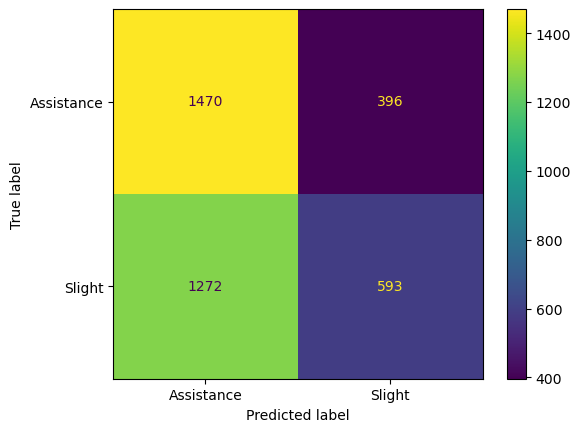

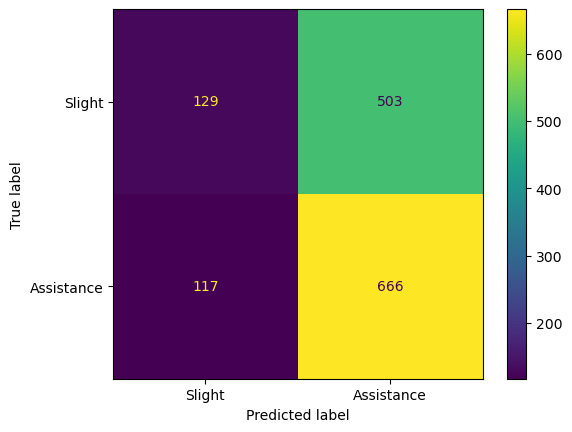

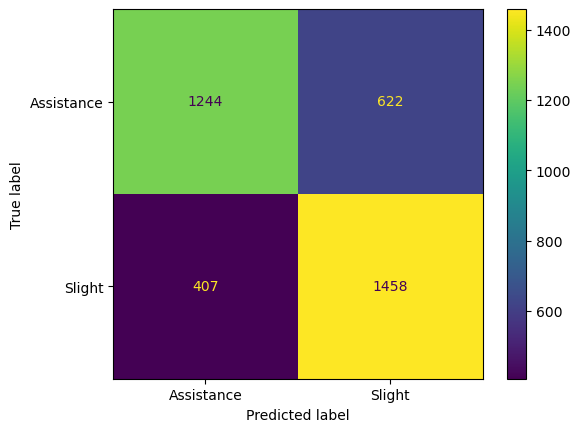

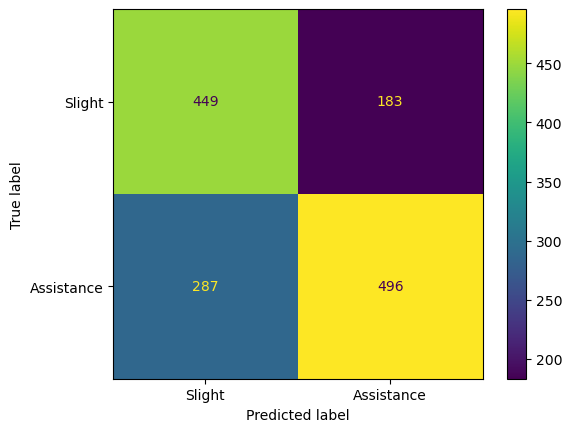

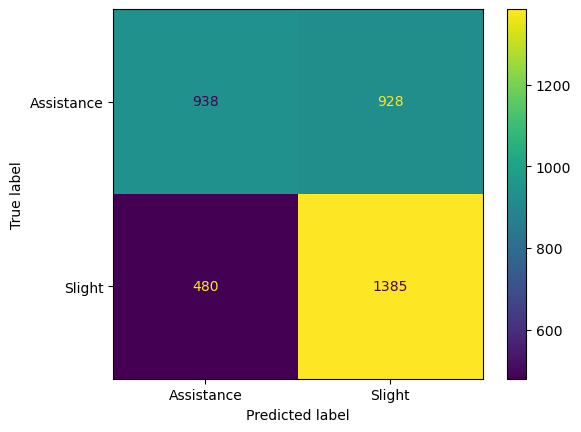

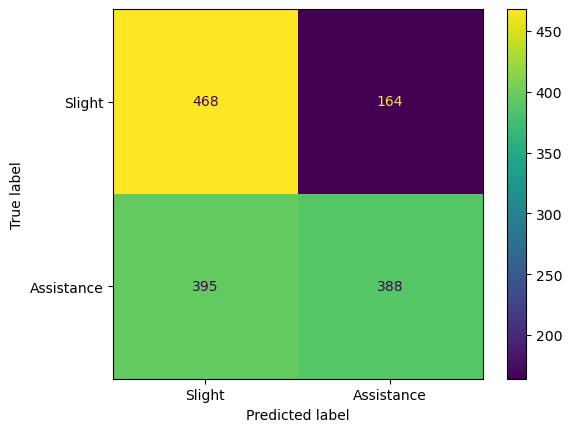

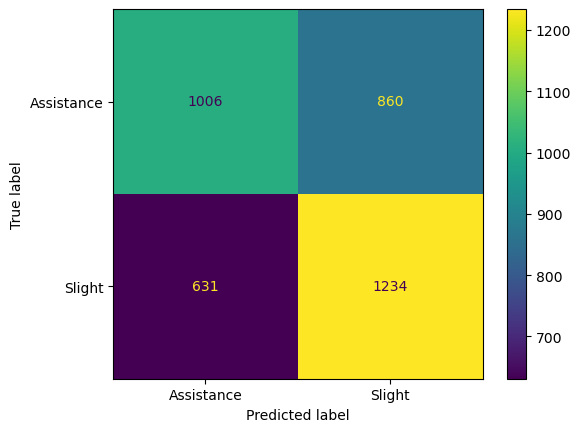

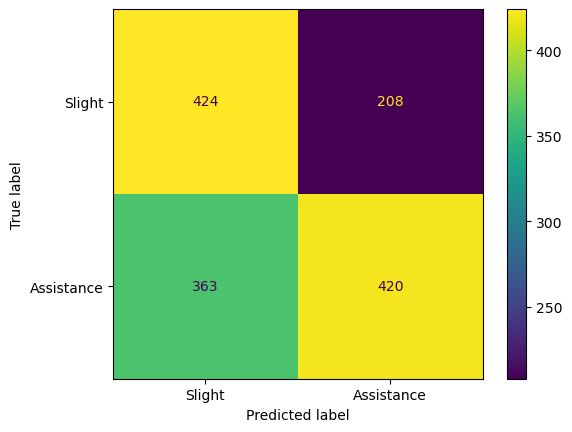

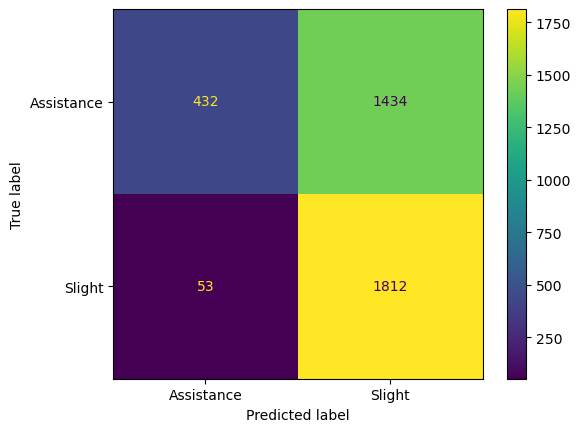

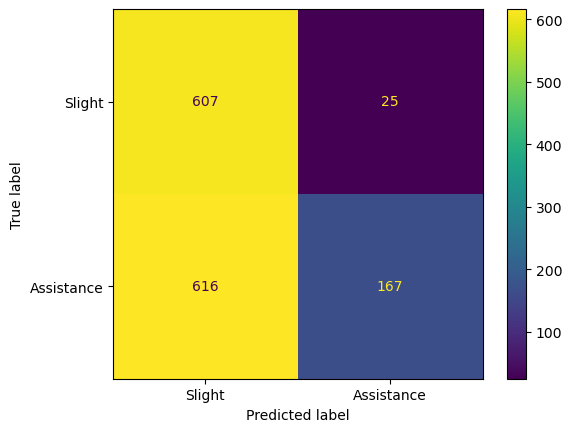

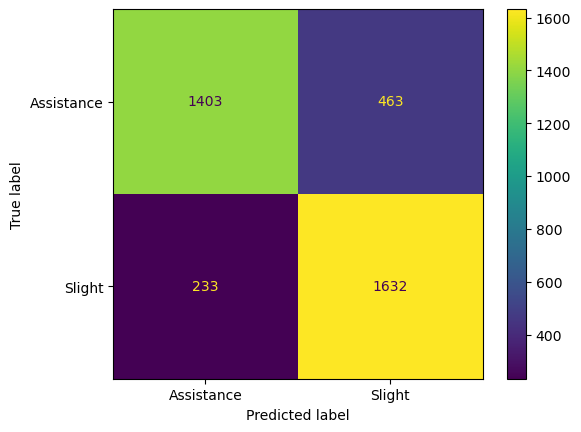

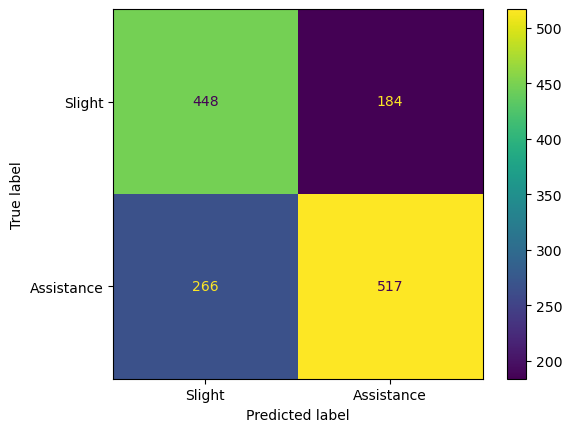

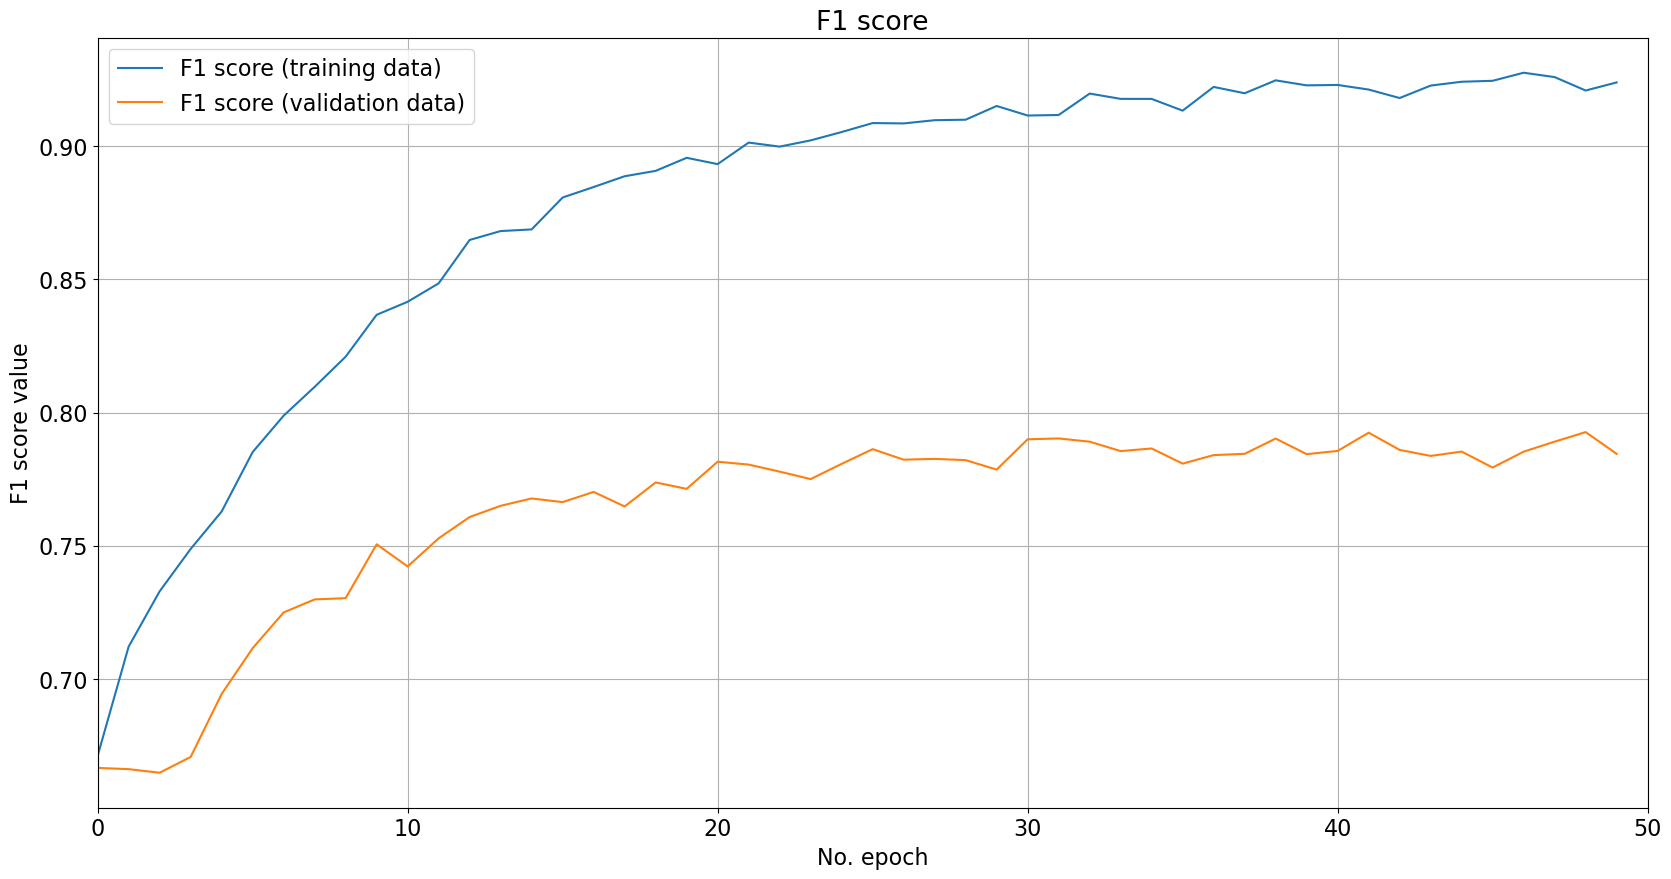

117/117 [==============================] - 0s 2ms/step
              precision  recall  f1-score   support
Assistance        0.965   0.915     0.939  1866.000
Slight            0.919   0.967     0.942  1865.000
accuracy          0.941   0.941     0.941     0.941
macro avg         0.942   0.941     0.941  3731.000
weighted avg      0.942   0.941     0.941  3731.000
              precision  recall  f1-score   support
Assistance        0.812   0.774     0.793   783.000
Slight            0.735   0.778     0.756   632.000
accuracy          0.776   0.776     0.776     0.776
macro avg         0.774   0.776     0.775  1415.000
weighted avg      0.778   0.776     0.776  1415.000


In [158]:
if city and cnn2d:

    print("[INFO] evaluating network...")

    Y_predicted = tasp_cnn.predict(x = array_test_images).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_paper.svg"

        plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
                              f1_score_name = F1_SCORE_NAME,
                              history = history)

        Y_train_predicted = tasp_cnn.predict(x = array_train_images).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')


# Data Summary

## Models times plot

### Sort

In [161]:
times = times.sort_values('time')

### Save csv

In [162]:
SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.csv"
times.to_csv(SAVE_PATH, index= True)

### Save fig

In [163]:
# LOAD_PATH = f"{REPORTS_TIMES_PATH}2022-05-23-15:28:04.csv"
# times = pd.read_csv(LOAD_PATH)

# ax = sns.barplot(x = 'time',
#                  y = 'model',
#                  palette='deep',
#                  data = times).set(title = f"Models Fitting Time (s)")
# plt.xlabel("Time (s)")

# SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.png"
# plt.savefig(SAVE_PATH)

## Models metrics file

In [229]:
from os.path import exists

city_name = 'Victoria'
victoria = True

reports_summary = pd.DataFrame()

cities = []
# MODEL_TIMESTAMP = '2022-08-02-10:10:19'

cities.append('leeds')  if leeds else None
cities.append('madrid') if madrid else None
cities.append(f'{city_name}') if UK else None

models_renaming = {'knn': 'KNN',
                   'convolution_1d': '1D-convolution',
                   'convolution_2d': '2D-convolution',
                   'nb': 'NB',
                   'svc': 'SVC',
                   'logistic_regression': 'Logistic-Regression',
                   'random_forest': 'Random-Forest',
                   'mlp': 'ML-Perceptron',                   
                  }
                   # 'auto_ml': 'AutoML'}

splits = ['train', 'test']
sorted_by_time_models_name = times.model

for split in splits:
    reports_summary = pd.DataFrame()

    for model_name in sorted_by_time_models_name:

        REPORT_PATH = f"{REPORTS_PATH}{model_name}/{split}/"

        for city_name in cities:

            REPORT_NAME  = f"{city_name}_{model_name}_report_{MODEL_TIMESTAMP}.csv"

            if exists(REPORT_PATH + REPORT_NAME):
                print(f"Found: {model_name} for {split}")
                report = pd.read_csv(REPORT_PATH + REPORT_NAME, index_col=[0])
                report.insert(0, 'split', split)
                report.insert(1, 'city', city_name)
                report.insert(2, 'model', models_renaming[model_name])

                reports_summary = pd.concat([reports_summary, report])

                reports_summary = reports_summary.sort_values(['city', 'model'], ascending = [True, True])

    if not reports_summary.empty:
        c_m = reports_summary['city'] + '_' + reports_summary['model']
        reports_summary.insert(0, 'c_m', c_m)

        SAVE_PATH =  f"{REPORTS_SUMMARY_PATH}/{split}/{MODEL_TIMESTAMP}.csv"

        reports_summary.insert(0, 'accident_type', reports_summary.index)
        reports_summary.to_csv(SAVE_PATH, index= True)

Found: nb for train
Found: knn for train
Found: logistic_regression for train
Found: random_forest for train
Found: svc for train
Found: mlp for train
Found: convolution_2d for train
Found: nb for test
Found: knn for test
Found: logistic_regression for test
Found: random_forest for test
Found: svc for test
Found: mlp for test
Found: convolution_2d for test


## Models scores plot

In [227]:
REPORT_PATH

'Reports/convolution_2d/test/'

Found: Reports/summary/train/2023-10-11-09:38:22.csv
Found: Reports/summary/test/2023-10-11-09:38:22.csv


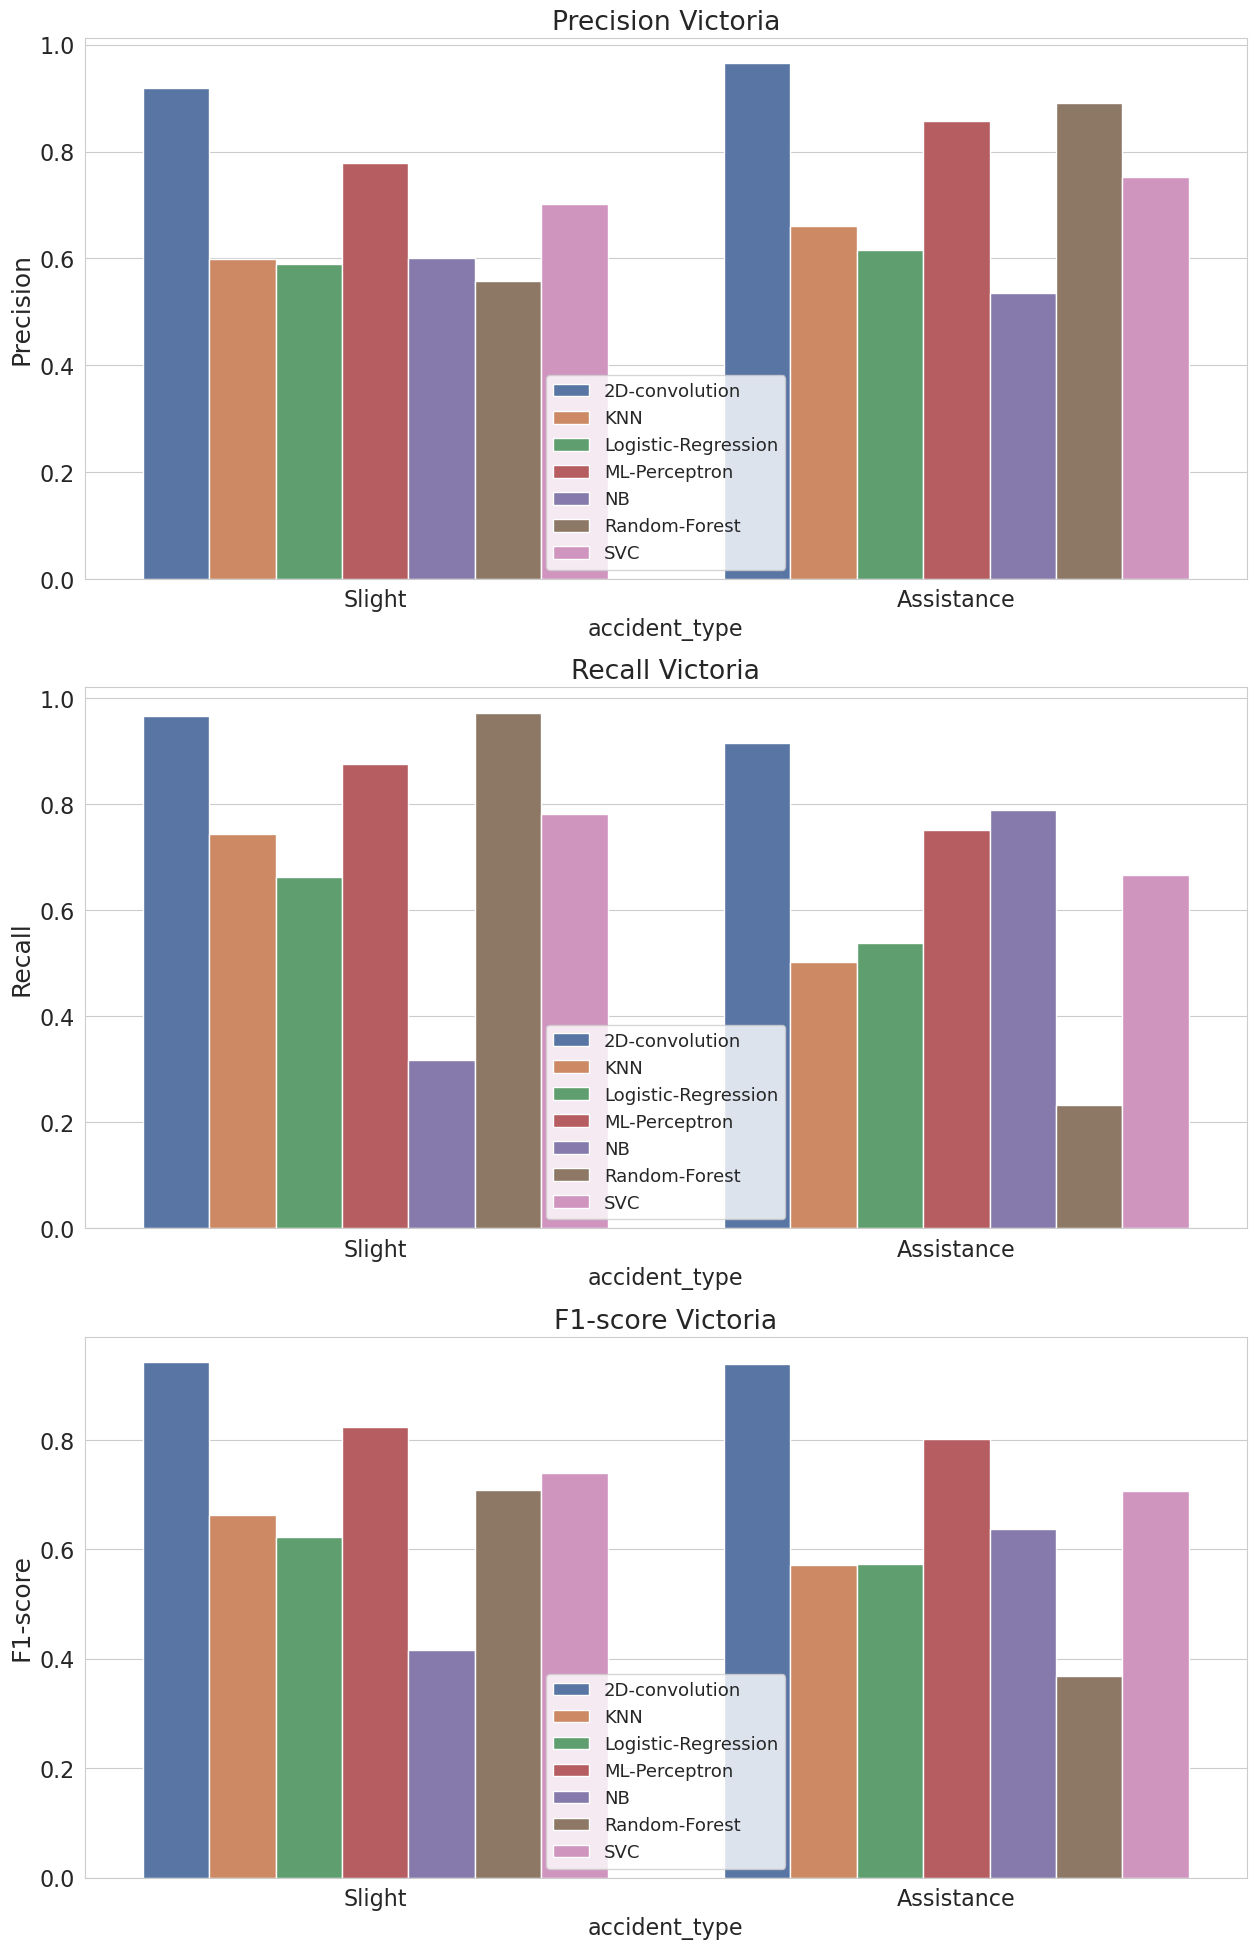

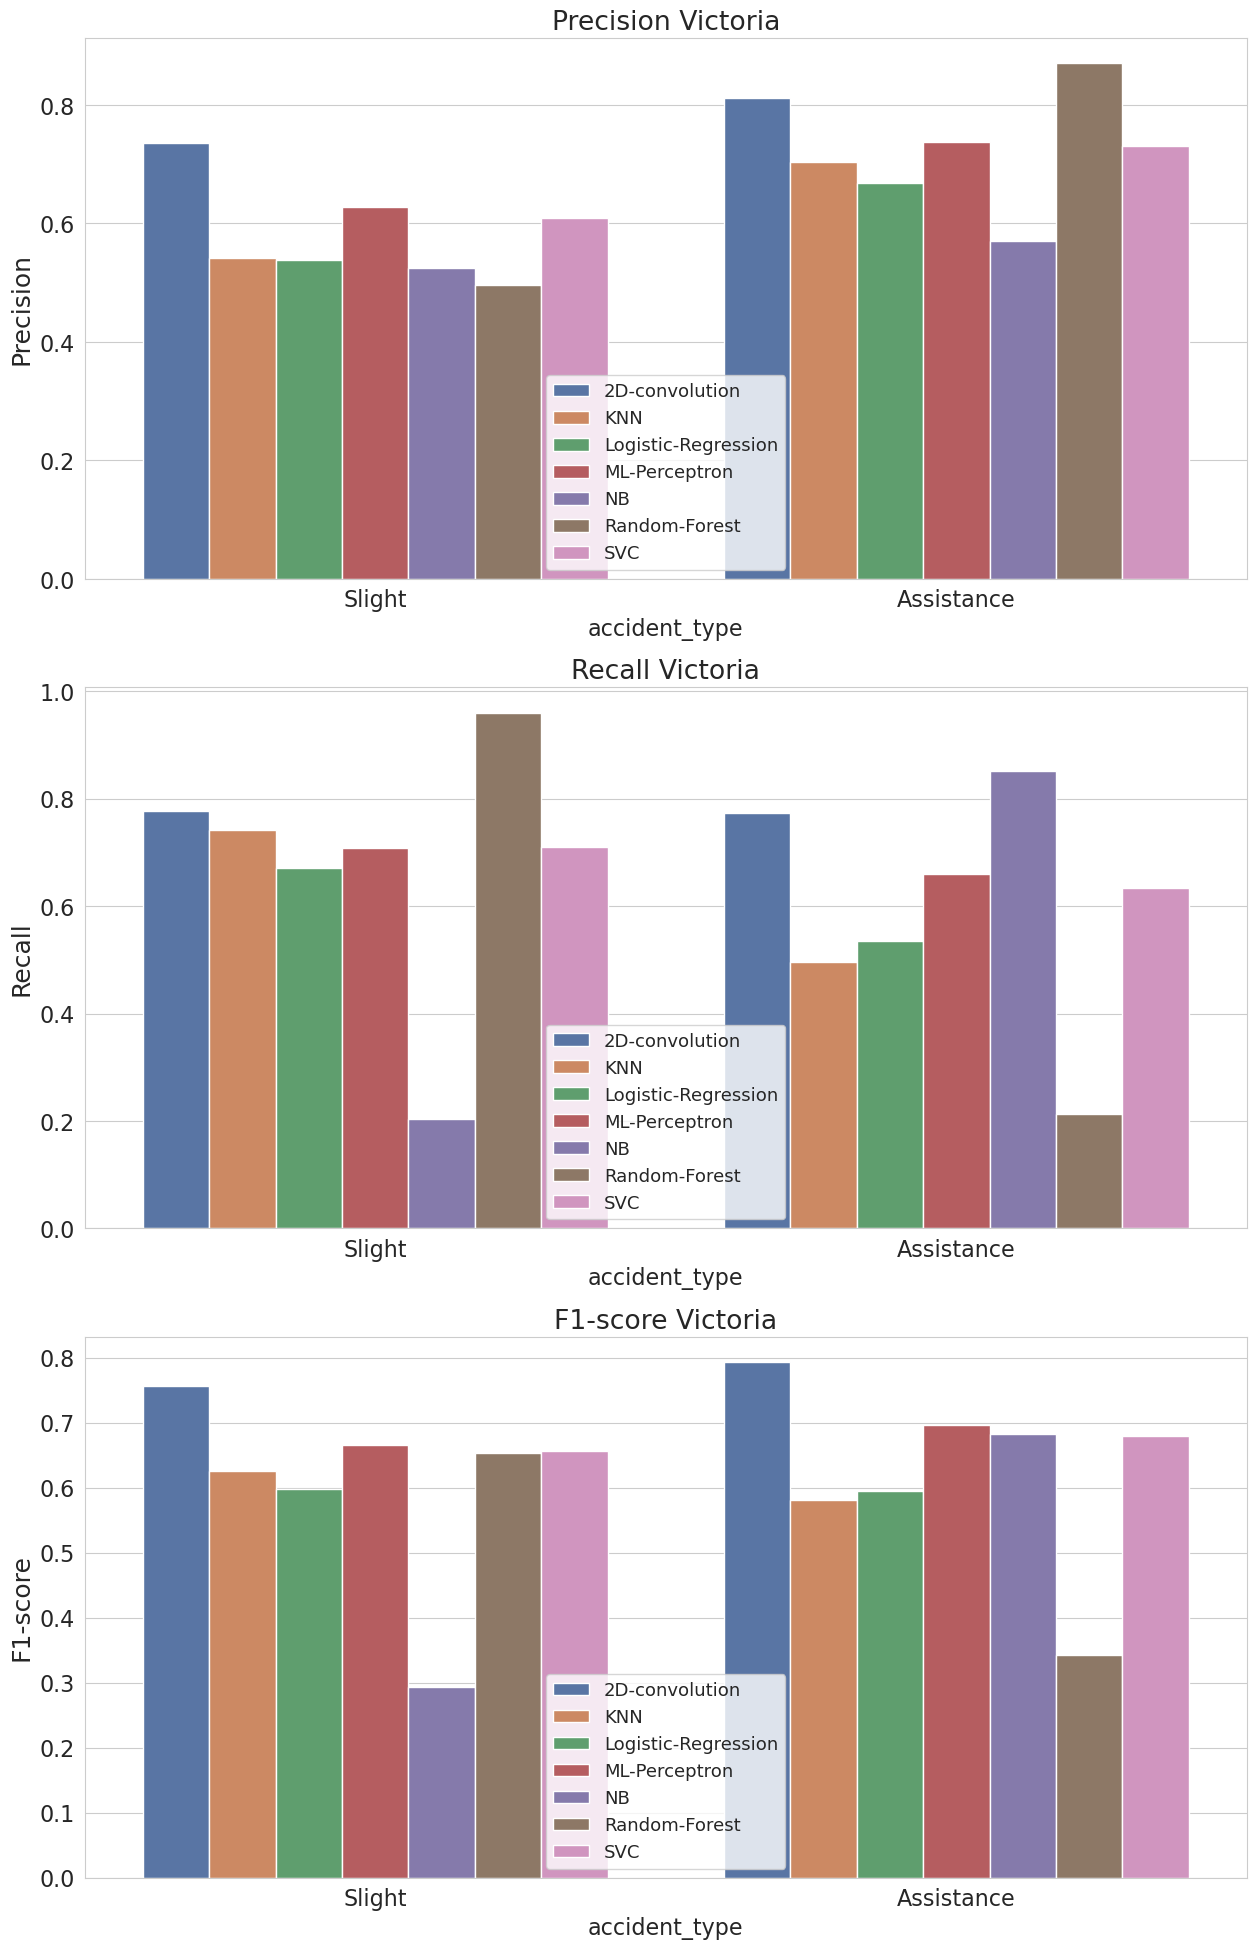

In [302]:
import seaborn as sns
import matplotlib.pyplot as plt 

city_name = 'Victoria'
victoria = True

MEASURE_TYPES  = ['precision', 'recall', 'f1-score']
# ACCIDENT_TYPES = ['Slight', 'Serious', 'Fatal']

ACCIDENT_TYPES = ['Slight', 'Assistance']

sns.set_style("whitegrid")

if leeds:
    leeds_reports_summary  = reports_summary[reports_summary['city'] == 'leeds']
if False: #madrid:
    madrid_reports_summary = reports_summary[reports_summary['city'] == 'madrid']
if UK:
    UK_reports_summary = reports_summary[reports_summary['city'] == city_name]
if victoria:
    UK_reports_summary = reports_summary[reports_summary['city'] == city_name]
# print(leeds_reports_summary.loc[ACCIDENT_TYPES])

for split in splits:
    
    REPORT_PATH = f"{REPORTS_SUMMARY_PATH}{split}/{MODEL_TIMESTAMP}.csv"

    if exists(REPORT_PATH):
        fig, axs = plt.subplots(len(MEASURE_TYPES), len(cities), figsize=(15,20))
        plt.subplots_adjust(bottom=0.05, top=0.97)

        print(f"Found: {REPORT_PATH}")

        report = pd.read_csv(REPORT_PATH, index_col=[0])

        if leeds:
            leeds_reports_summary  = report[report['city'] == 'leeds']
        if madrid:
            madrid_reports_summary = report[report['city'] == 'madrid']
        if UK:
            UK_reports_summary = report[report['city'] == city_name]

        for index, measure_type in enumerate(MEASURE_TYPES):

            capitalized_measure_type = measure_type.capitalize()

            # Si son dos ciudades el plot es bidimensional.
            if len(cities) > 1:
                axis_leeds = axs[index, 0]
                axis_madrid = axs[index, 1]
            else:
                axis_leeds = axis_madrid = axis_UK = axs[index]

            if leeds:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = leeds_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_leeds).set(title = f"{measure_type} Leeds")


            if madrid:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = madrid_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_madrid).set(title = f"{measure_type} Madrid")
            
            if UK:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = UK_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_UK)

            ax.set_ylabel(capitalized_measure_type, fontsize=18)
            ax.set(title = f"{capitalized_measure_type} {city_name}")
            ax.legend(loc='lower center', fontsize=13)

        SAVE_PATH = f"{REPORTS_SUMMARY_PATH}{split}/{MODEL_TIMESTAMP}.png"

        fig = fig.get_figure()
        
        fig.savefig(SAVE_PATH,  dpi=400)
plt.show()

In [198]:
plt.plot()

[]

In [193]:
city_name

'Victoria'

In [194]:
MODEL_TIMESTAMP

'2023-10-11-09:38:22'

In [197]:
import pandas as pd
import matplotlib.pyplot as plt

root_path = 'Reports/summary/test/'

all_cities_summaries = pd.DataFrame()

best_results_mapper = {'Birmingham': '2023-08-18-15:47:06',
                       'Sheffield':  '2023-08-18-17:08:06',
                       'Liverpool':  '2023-08-18-15:25:24',
                       'Southwark':  '2023-08-18-18:08:44',
                       'Manchester': '2023-08-18-17:44:54',
                       'Cornwall':   '2023-07-15-15:49:36'
                     }

for city_name, city_timestamp in best_results_mapper.items():
    city_summary = pd.read_csv(f"{root_path}/{city_timestamp}.csv", index_col=0)
    all_cities_summaries = pd.concat([all_cities_summaries, city_summary])

all_cities_summaries = all_cities_summaries.drop_duplicates()

casualty_types = ['Slight']

all_cities_summaries = all_cities_summaries[all_cities_summaries['model'] != '1D-convolution']
all_cities_summaries.index = all_cities_summaries.city

for casualty_type in casualty_types:
    current_casualty_type_all_cities_summaries = all_cities_summaries[all_cities_summaries['accident_type'] == casualty_type]


    current_casualty_type_all_cities_summaries.groupby('model')['f1-score'].plot(x='city', legend=True, figsize=(20, 10), title=f'Models F1-scores by city ({casualty_type} Accidents)', grid=True)
    plt.ylabel('F1-Score')
    plt.savefig(f"{casualty_type}_a.svg")
    plt.plot()

In [196]:
plt.plot()

[]